# Advanced Market Structure Algorithms



- Advanced Stock Pattern Prediction using LSTM with the Attention Mechanism in TensorFlow: A step by step Guide with Apple Inc. (AAPL) Data

https://drlee.io/advanced-stock-pattern-prediction-using-lstm-with-the-attention-mechanism-in-tensorflow-a-step-by-143a2e8b0e95



- Revolutionizing Time Series Prediction with LSTM with the Attention Mechanism

https://drlee.io/revolutionizing-time-series-prediction-with-lstm-with-the-attention-mechanism-090833a19af9

# Install Libraries

In [1]:
try:
    import vectorbt as vbt
except ImportError:
    url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
    !curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
    url = 'https://anaconda.org/conda-forge/ta-lib/0.5.1/download/linux-64/ta-lib-0.5.1-py311h9ecbd09_0.conda'
    !curl -L $url -o /content/ta-lib.conda
    !mkdir /content/ta-lib
    !unzip /content/ta-lib.conda -d /content/ta-lib
    !sudo apt-get install zstd
    !tar --zstd -xvf /content/ta-lib/pkg-ta-lib-0.5.1-py311h9ecbd09_0.tar.zst lib/python3.11/site-packages/talib --strip-components=3
    !rm -rf /content/ta-lib.conda /content/ta-lib
    import talib
    !pip install -U vectorbt[full-no-talib]

    import os
    os.kill(os.getpid(), 9)

In [2]:
!pip install ccxt -qqq
!pip install yfinance -qqq
!pip install mplfinance -qqq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 4.7 MB/s eta 0:00:00


In [3]:
!pip install tensorflow -qqq
!pip install keras -qqq

# Import Libraries

In [4]:
import sys
import os
import time
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib.animation import FuncAnimation
from numpy.linalg import norm
from scipy.stats import entropy
from scipy.stats import entropy
from sklearn.cluster import Birch
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

import ccxt
import logging
from pathlib import Path
from typing import List, Optional, Union

np.random.seed(0)

In [5]:
import time
from datetime import datetime, timedelta

# Get the current timestamp in milliseconds
now_timestamp_ms = int(datetime.now().timestamp() * 1000)

# Convert milliseconds timestamp to seconds
timestamp_sec = now_timestamp_ms / 1000

# Convert timestamp to datetime object
datetime_object = datetime.now().fromtimestamp(timestamp_sec)

# Format the datetime object to 'year-month-dayTHour:Min:SecZ'
# '%Y' - Year with century
# '%m' - Month as a zero-padded decimal number
# '%d' - Day of the month as a zero-padded decimal number
# 'T'  - Literal 'T'
# '%H' - Hour (24-hour clock) as a zero-padded decimal number
# '%M' - Minute as a zero-padded decimal number
# '%S' - Second as a zero-padded decimal number
# 'Z'  - Literal 'Z' (often used to denote UTC time, though this code gets local time)
year_month_day_hour_min_sec_z = datetime_object.strftime('%Y-%m-%dT%H:%M:%SZ')

print(f"Formatted Datetime: {year_month_day_hour_min_sec_z}")

Formatted Datetime: 2025-07-10T01:56:02Z


# Load Data


From any ccxt supported exchange.

coinbase, gemini, kraken, binanceus, etc

Recommended => Coinbase.



## CCXT

In [6]:
INSTRUMENT = "BTC/USDT"
TIMEFRAME = "4h" # 1h | 4h
EXCHANGE_ID = "binanceus"

In [7]:
# Instantiate the exchange
exchange: ccxt.Exchange = getattr(ccxt, EXCHANGE_ID)()

# Load the markets to get exchange information, including timeframes
exchange.load_markets()

# Get and print the supported timeframes
exchange_timeframes = exchange.timeframes

if exchange_timeframes:
    print(f"Supported timeframes for {EXCHANGE_ID.capitalize()}:")
    for timeframe in exchange_timeframes:
        print(timeframe)
else:
    print(f"Could not retrieve timeframes for {EXCHANGE_ID.capitalize()}.")

Supported timeframes for Binanceus:
1s
1m
3m
5m
15m
30m
1h
2h
4h
6h
8h
12h
1d
3d
1w
1M


In [8]:
# Configure logger
logging.basicConfig(level=logging.DEBUG, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

# Add a log message to see output
logger.info("Logger configured successfully.")

def fetch_ohlcv_with_retries(exchange: ccxt.Exchange, symbol: str, timeframe: str, since: int, limit: int, max_retries: int = 3) -> List[List[Union[int, float]]]:
    """Fetch OHLCV data with retry logic."""
    for attempt in range(max_retries):
        try:
            return exchange.fetch_ohlcv(symbol, timeframe, since, limit)
        except Exception as e:
            if attempt == max_retries - 1:
                logger.error(f"Failed to fetch {timeframe} {symbol} OHLCV after {max_retries} attempts: {e}")
                raise
    return []

def load_existing_data(filename: Path) -> pd.DataFrame:
    """Load existing OHLCV data if available."""
    if filename.exists():
        return pd.read_csv(filename, parse_dates=["timestamp"], index_col="timestamp")
    return pd.DataFrame(columns=["open", "high", "low", "close", "volume"])

def scrape_ohlcv(exchange: ccxt.Exchange, symbol: str, timeframe: str, since: int, until: int, limit: int, max_retries: int = 3) -> List[List[Union[int, float]]]:
    """Scrape historical OHLCV data from an exchange between two dates."""
    all_ohlcv: List[List[Union[int, float]]] = []

    while since < until:
        ohlcv: List[List[Union[int, float]]] = fetch_ohlcv_with_retries(exchange, symbol, timeframe, since, limit, max_retries)

        if not ohlcv:
            break

        since = ohlcv[-1][0] + 1  # Move forward in time
        all_ohlcv.extend(ohlcv)
        logger.info(f"{len(all_ohlcv)} {symbol} candles collected from {exchange.iso8601(all_ohlcv[0][0])} to {exchange.iso8601(all_ohlcv[-1][0])}")

    return all_ohlcv

def save_to_csv(filename: Path, data: pd.DataFrame) -> None:
    """Save OHLCV data to a CSV file, appending new data if necessary."""
    if filename.exists():
        data.to_csv(filename, mode='a', header=False)
    else:
        data.to_csv(filename)
    logger.info(f"Data saved to {filename}")

def scrape_and_save_candles(exchange_id: str, symbol: str, timeframe: str, since: Union[int, str], until: Union[int, str], limit: int, max_retries: int = 3, filename: Optional[str] = None, exchange_options: Optional[dict] = None) -> None:
    """Scrape OHLCV data and save to a CSV file, supporting resuming downloads."""

    if filename is None or len(filename) == 0:
        filename = f"{symbol.replace('/', '_')}_{timeframe}.csv".lower()

    exchange_options = exchange_options or {}
    exchange: ccxt.Exchange = getattr(ccxt, exchange_id)({'enableRateLimit': True, 'options': exchange_options})

    if isinstance(since, str):
        since = exchange.parse8601(since)
    if not until:
        until = exchange.milliseconds()
    elif isinstance(until, str):
        until = exchange.parse8601(until)

    exchange.load_markets()
    file_path = Path("./data/ccxt/") / exchange_id / filename
    file_path.parent.mkdir(parents=True, exist_ok=True)
    existing_data = load_existing_data(file_path)

    if not existing_data.empty:
        last_timestamp = existing_data.index[-1].timestamp() * 1000  # Convert to ms
        if last_timestamp > since:
            since = int(last_timestamp) + 1  # Resume from the next candle

    ohlcv = scrape_ohlcv(exchange, symbol, timeframe, since, until, limit, max_retries)

    if ohlcv:
        new_data = pd.DataFrame(ohlcv, columns=["timestamp", "open", "high", "low", "close", "volume"])
        new_data["timestamp"] = pd.to_datetime(new_data["timestamp"], unit='ms')
        if not new_data.empty:
            if not existing_data.empty:
                existing_data.reset_index(inplace=True)
                combined_data = pd.concat([existing_data, new_data]).drop_duplicates(subset=["timestamp"]).sort_values("timestamp")
            else:
                combined_data = new_data.drop_duplicates(subset=["timestamp"]).sort_values("timestamp")
            save_to_csv(file_path, combined_data)
            logger.info(f"Saved {len(new_data)} new candles from {new_data.iloc[0, 0]} to {new_data.iloc[-1, 0]} to {filename}")
        else:
            logger.warning("No new OHLCV data to save.")
    else:
        logger.warning("No new OHLCV data retrieved.")


In [9]:
EXCHANGE_ID, INSTRUMENT, TIMEFRAME

('binanceus', 'BTC/USDT', '4h')

In [10]:
def get_ccxt_data(exchange_id, symbol, timeframe, start_date="2019-06-01T00:00:00Z", end_date="2025-06-19T23:59:59Z"):
    """
    Loads historical data for a given symbol from a CSV file,
    or scrapes it if not found. Cleans and validates the data.
    """
    filepath = Path(f"./data/ccxt/{exchange_id}/{symbol.replace('/', '_')}_{timeframe}.csv".lower())

    try:
        # Load the data from the individual CSV file
        data = pd.read_csv(filepath, parse_dates=["timestamp"])
        if "Unnamed: 0" in data.columns:
            data.drop(columns=["Unnamed: 0"], inplace=True)
        return data
    except FileNotFoundError:
        print(f"Data file for {symbol} not found at {filepath}. Scraping data...")
        scrape_and_save_candles(
            exchange_id=exchange_id,
            symbol=symbol,
            timeframe=timeframe,
            since=start_date,
            until=end_date,
            limit=1000
        )
        # Try loading again after scraping
        try:
            data = pd.read_csv(filepath, parse_dates=["timestamp"])
            if "Unnamed: 0" in data.columns:
                data.drop(columns=["Unnamed: 0"], inplace=True)
            return data
        except Exception as e:
            print(f"Error loading scraped data for {symbol} from {filepath}: {e}")
            return pd.DataFrame()
    except Exception as e:
        print(f"Error loading or parsing data for {symbol} from {filepath}: {e}")
        return pd.DataFrame()


# "2025-06-20T23:59:59Z"
ohlcv = get_ccxt_data(exchange_id=EXCHANGE_ID, symbol=INSTRUMENT, timeframe=TIMEFRAME, start_date="2019-06-01T00:00:00Z", end_date=year_month_day_hour_min_sec_z)
ohlcv

Data file for BTC/USDT not found at data/ccxt/binanceus/btc_usdt_4h.csv. Scraping data...


,timestamp,open,high,low,close,volume
0,2019-09-23 08:00:00,9930.13,9930.13,9930.13,9930.13,0.00100
1,2019-09-23 12:00:00,9930.13,9930.13,9930.13,9930.13,0.00000
2,2019-09-23 16:00:00,9930.13,9930.13,9930.13,9930.13,0.00000
3,2019-09-23 20:00:00,9930.13,9930.13,9930.13,9930.13,0.00000
4,2019-09-24 00:00:00,9930.13,9930.13,9930.13,9930.13,0.00000
...,...,...,...,...,...,...
12690,2025-07-09 08:00:00,108803.57,109300.00,108596.61,109149.28,4.63964
12691,2025-07-09 12:00:00,109058.68,109837.75,108569.34,109213.63,15.19159
12692,2025-07-09 16:00:00,109213.57,111932.25,109100.00,111691.60,18.50570
12693,2025-07-09 20:00:00,111900.86,111934.84,110620.54,111475.16,9.89051


## Yahoo Finance


No enough data for the following:
- 'PI35697-USD'


**Indices for Alpha Generation:**
- USD Dollar Index (DXY/USDX/DX-Y.NYB)
- Trade-Weighted Dollar Index (DTWEXBGS)

*Why they matter for alpha generation:*
- They are proxies of **USD strength**, impacting global liquidity, capital flows, and inflation expectations.
- many risk assets, commodities, emerging markets, and cryptocurrencies are inversely correlated withthe dollar.
- Useful for both directional strategies and regime-based filters.




In [11]:

def fetch_and_save_yahoo_data(symbols, start_date, end_date, interval='1d', data_dir='./data/yahoo'):
    """
    Fetches historical data from Yahoo Finance and saves it as CSVs per symbol.

    Args:
        symbols (list): List of Yahoo Finance symbols.
        start_date (str): Start date in 'YYYY-MM-DD'.
        end_date (str): End date in 'YYYY-MM-DD'.
        interval (str): Data interval (e.g., '1d', '15m').
        data_dir (str): Directory to store downloaded CSV files.
    """
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    for symbol in symbols:
        try:
            print(f"Fetching data for {symbol}...")
            df = yf.download(symbol, start=start_date, end=end_date, interval=interval)
            df.dropna(inplace=True)
            if isinstance(df.columns, pd.MultiIndex):
                df.columns = df.columns.droplevel(1)
            df.columns = [col.lower() for col in df.columns]

            if not df.empty:
                filename = os.path.join(data_dir, f'{symbol.replace("-", "_").replace("=", "")}.csv')
                df.to_csv(filename)
                print(f"Saved data for {symbol} to {filename}")
            else:
                print(f"No data found for {symbol}")
        except Exception as e:
            print(f"Error fetching data for {symbol}: {e}")

def get_yahoo_data(symbol, timeframe='1d', data_dir='./data/yahoo', start_date=None, end_date=None):
    """
    Loads historical Yahoo data from CSV, or downloads and saves if not found.

    Args:
        symbol (str): Yahoo Finance symbol.
        timeframe (str): Interval (e.g., '1d', '15m').
        data_dir (str): Directory where CSVs are stored or saved.
        start_date (str): Start date if download is needed.
        end_date (str): End date if download is needed.

    Returns:
        pd.DataFrame: Cleaned OHLCV data.
    """
    filename_symbol = symbol.replace("-", "_").replace("=", "")
    filepath = os.path.join(data_dir, f'{filename_symbol}.csv')

    try:
        df = pd.read_csv(filepath, parse_dates=['Date'], index_col='Date')
        print(f"\nLoaded data for {symbol} from {filepath}")
    except FileNotFoundError:
        print(f"Data file for {symbol} not found. Attempting to download...")
        if not start_date or not end_date:
            raise ValueError("Start and end dates must be provided to download missing data.")
        try:
            df = yf.download(symbol, start=start_date, end=end_date, interval=timeframe)
            if isinstance(df.columns, pd.MultiIndex):
                df.columns = df.columns.droplevel(1)
            df.columns = [col.lower() for col in df.columns]

            if not df.empty:
                os.makedirs(data_dir, exist_ok=True)
                df.to_csv(filepath)
                print(f"Downloaded and saved data for {symbol} to {filepath}")
            else:
                print(f"No data found for {symbol} during download.")
                return pd.DataFrame()
        except Exception as e:
            print(f"Error downloading data for {symbol}: {e}")
            return pd.DataFrame()
    except Exception as e:
        print(f"Error reading data for {symbol}: {e}")
        return pd.DataFrame()

    # Convert columns to numeric
    for col in ['open', 'high', 'low', 'close', 'volume']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    critical_cols = [col for col in ['close', 'high', 'low'] if col in df.columns]
    if critical_cols:
        df.dropna(subset=critical_cols, how='all', inplace=True)
    else:
        print(f"Warning: Critical OHLC columns missing for {symbol}.")
        return pd.DataFrame()

    if df.empty or len(df) < 10:
        print(f"Warning: Not enough valid rows for {symbol}. Only {len(df)} rows.")
        return pd.DataFrame()

    return df


In [12]:
# ---- Parameters ----
# indices = ['^GSPC', '^DJI', '^IXIC', '^RUT', '^VIX', 'DX-Y.NYB']
# stocks = ['AAPL', 'AMZN', 'MSFT', 'NVDA', 'TSLA', 'INTC', 'QUBT', 'COIN', 'META']
# fx = ['EURUSD=X', 'GBPUSD=X', 'USDJPY=X', 'USDCHF=X', 'EURGBP=X', 'EURNZD=X', 'EURCHF=X', 'GBPNZD=X', 'GBPCHF=X']
# metals = ['^XAU', '^XAG']
# commodities = ['CL=F']
# crypto = ['BTC-USD', 'ETH-USD', 'SOL-USD', 'XRP-USD', 'LTC-USD', 'AAVE-USD', 'BNB-USD', 'TRX-USD', 'DOT-USD', 'XLM-USD']
indices = ['^GSPC', '^DJI', '^VIX', 'DX-Y.NYB']
stocks = ['AAPL', 'AMZN', 'MSFT', 'NVDA', 'COIN', 'META']
fx = ['EURUSD=X', 'GBPUSD=X', 'USDJPY=X', 'USDCHF=X', 'EURNZD=X', 'EURCHF=X', 'GBPNZD=X', 'GBPCHF=X']
metals = ['^XAU', '^XAG']
commodities = ['CL=F']
crypto = ['BTC-USD', 'ETH-USD', 'SOL-USD', 'XRP-USD']

symbols = indices + stocks + fx + metals + commodities + crypto
start_date = '2021-06-01'
end_date = '2025-07-01'
interval = '1d'
data_dir = './data/yahoo'

# Step 1: Fetch and store
fetch_and_save_yahoo_data(symbols, start_date, end_date, interval, data_dir)

# Step 2: Load a specific one later
# aapl_df = get_yahoo_data('AAPL', timeframe=interval, data_dir=data_dir, start_date=start_date, end_date=end_date)

Fetching data for ^GSPC...


/tmp/ipython-input-11-1314066763.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-11-1314066763.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-11-1314066763.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for ^GSPC to ./data/yahoo/^GSPC.csv
Fetching data for ^DJI...
Saved data for ^DJI to ./data/yahoo/^DJI.csv
Fetching data for ^VIX...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-11-1314066763.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-11-1314066763.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for ^VIX to ./data/yahoo/^VIX.csv
Fetching data for DX-Y.NYB...
Saved data for DX-Y.NYB to ./data/yahoo/DX_Y.NYB.csv
Fetching data for AAPL...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-11-1314066763.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)
[*********************100%***********************]  1 of 1 completed


Saved data for AAPL to ./data/yahoo/AAPL.csv
Fetching data for AMZN...
Saved data for AMZN to ./data/yahoo/AMZN.csv
Fetching data for MSFT...


/tmp/ipython-input-11-1314066763.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-11-1314066763.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)
[*********************100%***********************]  1 of 1 completed

Saved data for MSFT to ./data/yahoo/MSFT.csv
Fetching data for NVDA...



/tmp/ipython-input-11-1314066763.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-11-1314066763.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for NVDA to ./data/yahoo/NVDA.csv
Fetching data for COIN...
Saved data for COIN to ./data/yahoo/COIN.csv
Fetching data for META...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-11-1314066763.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-11-1314066763.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for META to ./data/yahoo/META.csv
Fetching data for EURUSD=X...
Saved data for EURUSD=X to ./data/yahoo/EURUSDX.csv
Fetching data for GBPUSD=X...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-11-1314066763.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-11-1314066763.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for GBPUSD=X to ./data/yahoo/GBPUSDX.csv
Fetching data for USDJPY=X...
Saved data for USDJPY=X to ./data/yahoo/USDJPYX.csv
Fetching data for USDCHF=X...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-11-1314066763.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-11-1314066763.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for USDCHF=X to ./data/yahoo/USDCHFX.csv
Fetching data for EURNZD=X...
Saved data for EURNZD=X to ./data/yahoo/EURNZDX.csv
Fetching data for EURCHF=X...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-11-1314066763.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-11-1314066763.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for EURCHF=X to ./data/yahoo/EURCHFX.csv
Fetching data for GBPNZD=X...
Saved data for GBPNZD=X to ./data/yahoo/GBPNZDX.csv
Fetching data for GBPCHF=X...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-11-1314066763.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)
[*********************100%***********************]  1 of 1 completed


Saved data for GBPCHF=X to ./data/yahoo/GBPCHFX.csv
Fetching data for ^XAU...
Saved data for ^XAU to ./data/yahoo/^XAU.csv
Fetching data for ^XAG...


/tmp/ipython-input-11-1314066763.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^XAG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2021-06-01 -> 2025-07-01)')
/tmp/ipython-input-11-1314066763.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


No data found for ^XAG
Fetching data for CL=F...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-11-1314066763.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)
[*********************100%***********************]  1 of 1 completed

Saved data for CL=F to ./data/yahoo/CLF.csv
Fetching data for BTC-USD...



/tmp/ipython-input-11-1314066763.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)
[*********************100%***********************]  1 of 1 completed

Saved data for BTC-USD to ./data/yahoo/BTC_USD.csv
Fetching data for ETH-USD...



/tmp/ipython-input-11-1314066763.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)
[*********************100%***********************]  1 of 1 completed


Saved data for ETH-USD to ./data/yahoo/ETH_USD.csv
Fetching data for SOL-USD...


/tmp/ipython-input-11-1314066763.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)
[*********************100%***********************]  1 of 1 completed

Saved data for SOL-USD to ./data/yahoo/SOL_USD.csv
Fetching data for XRP-USD...


Saved data for XRP-USD to ./data/yahoo/XRP_USD.csv


## Extract Price Series


## ✅ **Proposal**

We want to construct a custom price like:

$$
\text{Price}_{\text{custom}} = w_1 \cdot \text{High}_t + w_2 \cdot \text{Low}_t + w_3 \cdot \text{Close}_t
$$

Where:

* $w_1, w_2, w_3$ are weights, possibly adaptive or fixed.
* This synthetic series is then used as the "price" input into your features, indicators, or models.

---

## 🔍 Why This Can Be Powerful

Most indicators use **close-only**, which discards valuable intraday range information. A weighted blend:

* Captures **intrabar structure**.
* Smooths volatility.
* Can encode **market sentiment** better than raw closes.

---

## 📐 Common Weighted Price Schemes

Here are some **existing techniques** that can inspire or be combined with your idea:

### 1. **Typical Price**

$$
\text{TP} = \frac{High + Low + Close}{3}
$$

### 2. **Weighted Close**

$$
\text{WC} = \frac{High + Low + 2 \cdot Close}{4}
$$

### 3. **OHLC Average**

$$
\text{OHLC} = \frac{Open + High + Low + Close}{4}
$$

### 4. **Mid Price**

$$
\text{Mid} = \frac{High + Low}{2}
$$

### 5. **Custom Weights (Your Idea)**

$$
\text{P}_{\text{custom}} = \alpha \cdot H + \beta \cdot L + \gamma \cdot C \quad \text{where} \quad \alpha + \beta + \gamma = 1
$$

You can learn these weights in a model, optimize for Sharpe, or define them heuristically.

---

## 💡 How to Choose the Weights

### 1. **Heuristic**

Try:

* $\alpha = 0.25, \beta = 0.25, \gamma = 0.5$
* $\gamma = 1.0$ (use close-only as baseline)
* Use volatility to scale H/L contributions.

### 2. **Machine Learning / Optimization**

* Use **Sharpe-ratio maximization** to learn optimal weights.
* Or use a **regression model** to predict next return and fit the weights that best predict it.

### 3. **Reinforcement Learning Integration**

* Let your RL agent learn the weights $\alpha, \beta, \gamma$ as parameters over time.
* Plug into observation: `obs = price_custom`, where `price_custom = weighted(H, L, C)`.

---

## 🧪 Implementation Snippet (Python)

```python
def custom_price(high, low, close, alpha=0.3, beta=0.3, gamma=0.4):
    return alpha * high + beta * low + gamma * close
```

Or, to optimize weights dynamically:

```python
def adaptive_price(high, low, close, vol):
    alpha = 0.3 + 0.2 * vol
    beta = 0.3 - 0.1 * vol
    gamma = 1 - alpha - beta
    return alpha * high + beta * low + gamma * close
```

---

## 🧠 Strategic Use in a Trading Pipeline

* Use as the **main input price** to:

  * Indicators (RSI, MACD, Bollinger)
  * Pattern detectors (reversals, breakouts)
  * RL environments (in `price_matrix`)
* Apply it to **volume-weighted** or **volatility-adjusted** views
* Use difference or change in this price to detect **price aggression** or **liquidity pressure**



In [13]:
# === STEP 1: Get price series ===
# dates = pd.date_range(start="2021-01-01", periods=15, freq="M")
# prices = np.array([
#     30000, 33000, 29000, 35000, 34000,
#     38000, 36000, 42000, 40000, 48000,
#     47000, 52000, 50000, 58000, 62000
# ], dtype=float)
# Extract price series
dates = ohlcv["timestamp"].values
highs = ohlcv["high"].values
lows = ohlcv["low"].values
closes = ohlcv["close"].values
volumes = ohlcv["volume"].values

prices = closes

# Pivots - Price Rejection Points



Pivots => Support/Resistance


## Bin-Based Algorithm for Pivots

**BinPivots**


```pine
indicator("BIN Based Support and Resistance [SS]", overlay=true)
lookback = input.int(500, "Lookback Length")
displaylabel = input.string("On SR lines", "Where would you like the statistics to display?", ["On SR lines", "Table", "OFF"])
offset = input.int(100, "Offset the lines ahead")
```


[Link](https://www.tradingview.com/script/AtzwB4pU-BIN-Based-Support-and-Resistance-SS/#:~:text=Bin%20Based%20Support%20and%20Resistance%20Levels%20dynamically%20adjust%20to%20ranges,at%20random%20peaks%20and%20valleys.&text=You%20can%20see%20these%202%20SR%20lines%20are%20close%20together.)


In [14]:
ohlcv.shape

(12695, 6)

In [15]:

def bin_based_support_resistance(df: pd.DataFrame, lookback: int = 500):
    # Ensure enough data
    if len(df) < lookback:
        raise ValueError("Not enough data for the given lookback period.")

    # Slice recent lookback window
    df_lb = df.tail(lookback).copy()

    max_close = df_lb['close'].max()
    min_close = df_lb['close'].min()
    bin_size = (max_close - min_close) / 10

    # Bin thresholds
    lbin = [min_close + i * bin_size for i in range(1, 6)]
    ubin = [max_close - i * bin_size for i in reversed(range(1, 6))]

    # Bin membership logic
    def assign_bin(value):
        thresholds = lbin + ubin
        for i in range(10):
            lower = min_close + i * bin_size
            upper = lower + bin_size if i < 9 else float('inf')
            if lower <= value < upper:
                return i + 1
        return None

    df_lb['bin'] = df_lb['close'].apply(assign_bin)

    # Collect values per bin
    bin_closes = {i: [] for i in range(1, 11)}
    for i in range(lookback):
        b = df_lb['bin'].iloc[i]
        if b is not None:
            bin_closes[b].append(df_lb['close'].iloc[i])

    # Compute average SR levels
    sr_levels = {f'sr{i}': np.mean(bin_closes[i]) if bin_closes[i] else np.nan for i in range(1, 11)}

    # Rejection statistic calculation
    def calculate_statistics(level, df_slice):
        if np.isnan(level):
            return np.nan, np.nan

        bullish_rejection = (df_slice['high'].shift(2) >= level) & (df_slice['close'] < level)
        bearish_rejection = (df_slice['low'].shift(2) <= level) & (df_slice['close'] > level)

        reject_bull = bullish_rejection.sum()
        reject_bear = bearish_rejection.sum()
        total = reject_bull + reject_bear

        if total == 0:
            return np.nan, np.nan

        support_success = (reject_bear / total) * 100
        resistance_success = (reject_bull / total) * 100
        return support_success, resistance_success

    stats = {}
    for i in range(1, 11):
        sr = sr_levels[f'sr{i}']
        support_success, resistance_success = calculate_statistics(sr, df_lb)
        stats[f'sr{i}_ss'] = support_success
        stats[f'sr{i}_rs'] = resistance_success

    return sr_levels, stats


In [16]:
sr_levels, sr_stats = bin_based_support_resistance(ohlcv, lookback=500)

In [17]:
sr_levels

{'sr1': np.float64(84924.395),
 'sr2': np.float64(87851.28125),
 'sr3': np.float64(91458.15333333334),
 'sr4': np.float64(94205.60406779662),
 'sr5': np.float64(96342.10064516128),
 'sr6': np.float64(99397.45),
 'sr7': np.float64(102714.89490566037),
 'sr8': np.float64(104856.33939597316),
 'sr9': np.float64(107777.61450819671),
 'sr10': np.float64(109920.11367346937)}

In [18]:
sr_stats

{'sr1_ss': np.float64(61.53846153846154),
 'sr1_rs': np.float64(38.46153846153847),
 'sr2_ss': np.float64(80.0),
 'sr2_rs': np.float64(20.0),
 'sr3_ss': np.float64(100.0),
 'sr3_rs': np.float64(0.0),
 'sr4_ss': np.float64(63.1578947368421),
 'sr4_rs': np.float64(36.84210526315789),
 'sr5_ss': np.float64(63.1578947368421),
 'sr5_rs': np.float64(36.84210526315789),
 'sr6_ss': np.float64(75.0),
 'sr6_rs': np.float64(25.0),
 'sr7_ss': np.float64(65.21739130434783),
 'sr7_rs': np.float64(34.78260869565217),
 'sr8_ss': np.float64(54.32098765432099),
 'sr8_rs': np.float64(45.67901234567901),
 'sr9_ss': np.float64(50.72463768115942),
 'sr9_rs': np.float64(49.275362318840585),
 'sr10_ss': np.float64(35.483870967741936),
 'sr10_rs': np.float64(64.51612903225806)}

In [19]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
import matplotlib.patheffects as pe

# Define exact Pine-style gradient colors
pine_gradient_hex = [
    "#ff00c8", "#e100ff", "#0d00ff", "#007bff", "#00ffd5", "#00ff15",
    "#00ff15", "#ffc400", "#ff7700", "#ff1500", "#ff008c", "#e3000b"
]

pine_gradient_rgb = [tuple(int(h[i:i+2], 16)/255 for i in (1, 3, 5)) for h in pine_gradient_hex]

pine_cmap = LinearSegmentedColormap.from_list("pine_gradient", pine_gradient_rgb)

def bin_based_sr_plot(df, lookback=500, offset=100, display="label", bins=10, custom_levels=None, export_path=None):
    close = df['close']
    high = df['high']
    low = df['low']

    max_close = close.rolling(lookback).max()
    min_close = close.rolling(lookback).min()

    sr_levels = []

    if custom_levels:
        sr_levels = sorted(custom_levels)
    else:
        diff = (max_close - min_close) / bins
        for i in range(bins):
            sr_levels.append(min_close + diff * (i + 0.5))

    # Compute support/resistance success
    def calc_stats(level):
        bull_reject = ((high.shift(2) >= level) & (close < level)).rolling(lookback).sum()
        bear_reject = ((low.shift(2) <= level) & (close > level)).rolling(lookback).sum()
        total = bull_reject + bear_reject
        support_success = (bear_reject / total * 100).fillna(0)
        resistance_success = (bull_reject / total * 100).fillna(0)
        return support_success, resistance_success

    support_success_list = []
    resistance_success_list = []
    for level in sr_levels:
        ss, rs = calc_stats(level)
        support_success_list.append(ss)
        resistance_success_list.append(rs)

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 8))
    df['close'].plot(ax=ax, label='Close', color='gray', alpha=0.6)
    x = np.arange(len(df))
    latest_idx = x[-1]
    labels = []

    norm = plt.Normalize(0, len(sr_levels)-1)
    scalar_map = cm.ScalarMappable(norm=norm, cmap=pine_cmap)

    for i, level in enumerate(sr_levels):
        color = scalar_map.to_rgba(i)
        y = level.iloc[-1] if isinstance(level, pd.Series) else level
        ax.axhline(y=y, color=color, lw=2, alpha=0.8)

        # Tooltip-like label
        if display in ["label", "both"]:
            txt = f"SR {i+1}\nSS: {support_success_list[i].iloc[-1]:.1f}%\nRS: {resistance_success_list[i].iloc[-1]:.1f}%"
            label = ax.text(
                latest_idx + offset * 0.9, y, txt,
                fontsize=9, color='black', ha='left', va='center',
                bbox=dict(boxstyle="round,pad=0.3", fc=color, ec="black", alpha=0.8),
                path_effects=[pe.withStroke(linewidth=2, foreground="white")]
            )
            labels.append(label)

    # Optional table
    if display in ["table", "both"]:
        cell_text = []
        for i in range(len(sr_levels)):
            row = [
                f"SR {i+1}",
                f"{support_success_list[i].iloc[-1]:.1f}%",
                f"{resistance_success_list[i].iloc[-1]:.1f}%"
            ]
            cell_text.append(row)
        table = plt.table(
            cellText=cell_text,
            colLabels=["Level", "Support Success", "Resistance Success"],
            loc="bottom", cellLoc='center', colColours=["#303030"]*3
        )
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1, 1.5)
        plt.subplots_adjust(left=0.1, bottom=0.2)

    ax.set_title("BIN-Based Support & Resistance Levels")
    ax.legend()
    ax.grid(True)

    if export_path:
        plt.savefig(export_path, bbox_inches="tight")
    plt.show()


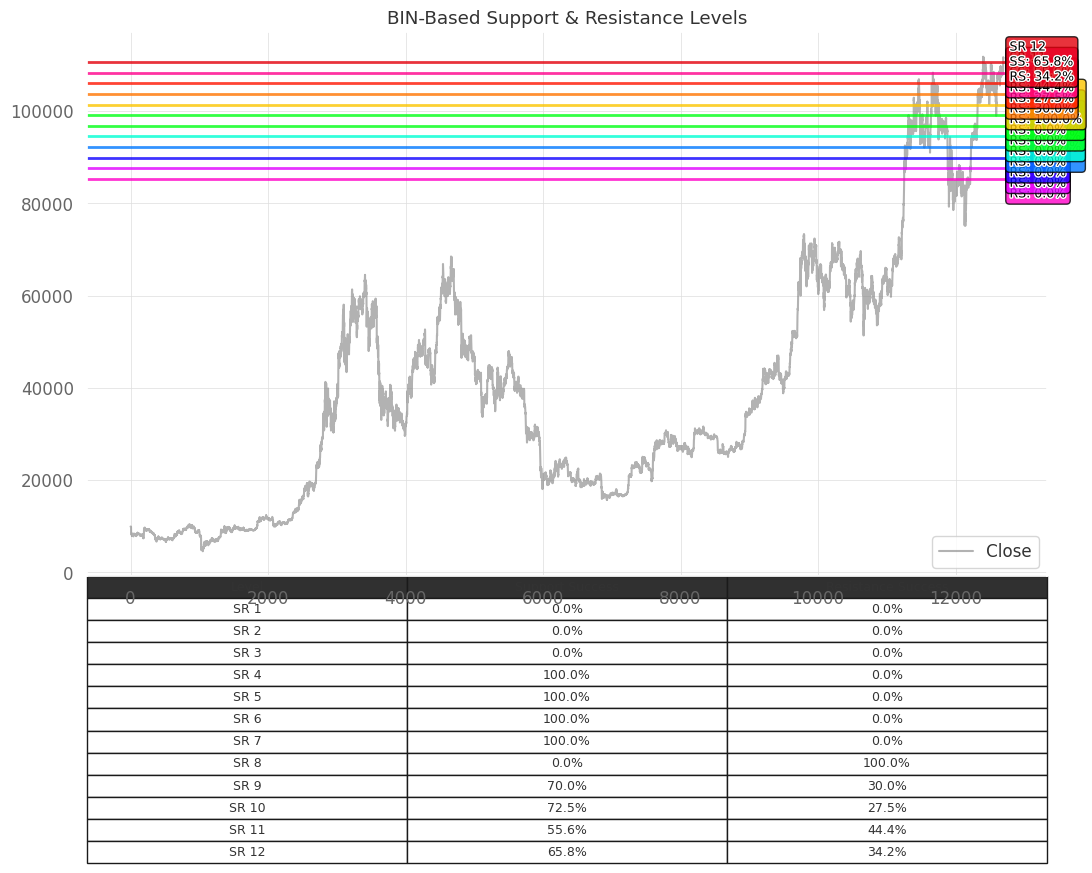

In [20]:
#
bin_based_sr_plot(
    df=ohlcv,
    lookback=500,
    offset=100,
    display="both",  # options: "label", "table", "both"
    bins=12,         # or use `custom_levels=[...prices...]`
    export_path="sr_levels.png"
)


In [21]:
import plotly.graph_objects as go


def bin_based_sr_plot_hover(
    df,
    lookback=500,
    offset=100,
    bins=10,
    custom_levels=None,
    display="both"
):
    df = df.copy()
    df = df[-lookback:].reset_index(drop=True)

    high, low, close = df["high"], df["low"], df["close"]

    max_p = close.max()
    min_p = close.min()

    if custom_levels:
        sr_levels = sorted(custom_levels)
        bins = len(sr_levels)
    else:
        step = (max_p - min_p) / bins
        sr_levels = [min_p + step * i for i in range(1, bins + 1)]

    def calculate_stats(level):
        bull_reject = (high.shift(2) >= level) & (close < level)
        bear_reject = (low.shift(2) <= level) & (close > level)
        bull_count = bull_reject.sum()
        bear_count = bear_reject.sum()
        total = bull_count + bear_count
        if total == 0:
            return 0, 0
        return round(bear_count / total * 100, 2), round(bull_count / total * 100, 2)

    support_success = []
    resistance_success = []

    for lvl in sr_levels:
        s, r = calculate_stats(lvl)
        support_success.append(s)
        resistance_success.append(r)

    # Gradient colors from Pine
    gradient_colors = [
        "#ff00c8", "#e100ff", "#0d00ff", "#007bff", "#00ffd5", "#00ff15",
        "#00ff15", "#ffc400", "#ff7700", "#ff1500", "#ff008c", "#e3000b"
    ][:bins]

    # Plot
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        y=close,
        x=df.index,
        mode='lines',
        name='Close',
        line=dict(color='white', width=1)
    ))

    for i, level in enumerate(sr_levels):
        fig.add_trace(go.Scatter(
            x=[0, lookback + offset],
            y=[level, level],
            mode="lines",
            name=f"SR {i+1}",
            line=dict(color=gradient_colors[i], width=2),
            hoverinfo="text",
            hovertext=(
                f"SR Level: {level:.2f}<br>"
                f"Support Success: {support_success[i]}%<br>"
                f"Resistance Success: {resistance_success[i]}%"
            ),
            showlegend=False
        ))

    if display in ["table", "both"]:
        table_data = {
            "SR Level": [f"{lvl:.2f}" for lvl in sr_levels],
            "Support Success (%)": support_success,
            "Resistance Success (%)": resistance_success
        }
        table_df = pd.DataFrame(table_data)
        print(table_df)

    fig.update_layout(
        title="Bin-Based Support and Resistance with Hover Tooltips",
        xaxis_title="Index",
        yaxis_title="Price",
        plot_bgcolor="black",
        paper_bgcolor="black",
        font=dict(color="white")
    )

    return fig


In [22]:
#
fig = bin_based_sr_plot_hover(ohlcv)
fig.show()

    SR Level  Support Success (%)  Resistance Success (%)
0   86919.93                85.71                   14.29
1   89684.28               100.00                    0.00
2   92448.64                85.71                   14.29
3   95213.00                40.91                   59.09
4   97977.36               100.00                    0.00
5  100741.71                81.82                   18.18
6  103506.07                53.73                   46.27
7  106270.43                47.83                   52.17
8  109034.78                51.67                   48.33
9  111799.14                 0.00                  100.00


In [23]:

def compute_bins(df, lookback=500, num_bins=10):
    recent_data = df.tail(lookback)
    min_price = recent_data['close'].min()
    max_price = recent_data['close'].max()
    bin_edges = np.linspace(min_price, max_price, num_bins + 1)
    return bin_edges


In [24]:
def group_closes_by_bin(df, bin_edges):
    bin_means = []
    for i in range(len(bin_edges) - 1):
        in_bin = df['close'][(df['close'] >= bin_edges[i]) & (df['close'] < bin_edges[i+1])]
        if not in_bin.empty:
            bin_means.append(in_bin.mean())
        else:
            bin_means.append(None)
    return bin_means


In [25]:
def calculate_statistics(df, level, lookback):
    highs = df['high'].shift(2)
    lows = df['low'].shift(2)
    closes = df['close']

    bull_rejects = ((highs >= level) & (closes < level)).sum()
    bear_rejects = ((lows <= level) & (closes > level)).sum()

    total = bull_rejects + bear_rejects
    if total == 0:
        return (0.0, 0.0)

    support_success = bear_rejects / total * 100
    resistance_success = bull_rejects / total * 100
    return support_success, resistance_success


In [26]:
import plotly.graph_objects as go
from plotly.colors import qualitative

def plot_sr_lines(df, bin_levels, support_stats, resistance_stats, colors, offset=100):
    fig = go.Figure()

    # OHLC chart
    fig.add_trace(go.Candlestick(
        x=df.index, open=df['open'], high=df['high'],
        low=df['low'], close=df['close'], name="Price"))

    # Add SR lines
    for i, level in enumerate(bin_levels):
        if level is not None:
            fig.add_trace(go.Scatter(
                x=[df.index[-offset], df.index[-1]],
                y=[level, level],
                mode='lines',
                line=dict(color=colors[i % len(colors)], width=2),
                name=f"SR {i+1}",
                hovertemplate=f"<b>SR {i+1}</b><br>Level: {level:.2f}<br>Support Success: {support_stats[i]:.2f}%<br>Resistance Success: {resistance_stats[i]:.2f}%",
                showlegend=False
            ))

    fig.update_layout(title="Gradient SR Lines with Stats", hovermode="x unified")
    return fig


In [27]:
lookback = 500
bin_edges = compute_bins(ohlcv, lookback)
bin_levels = group_closes_by_bin(ohlcv.tail(lookback), bin_edges)

support_stats, resistance_stats = zip(*[
    calculate_statistics(ohlcv.tail(lookback), level, lookback) if level else (0, 0)
    for level in bin_levels
])


In [28]:
# Gradient colors similar to Pine Script
colors = [
    '#ff00c8', '#e100ff', '#0d00ff', '#007bff', '#00ffd5',
    '#00ff15', '#00ff15', '#ffc400', '#ff7700', '#ff1500', '#ff008c', '#e3000b'
]

fig = plot_sr_lines(ohlcv, bin_levels, support_stats, resistance_stats, colors)
fig.show()

## Birch Algorithm for Pivots


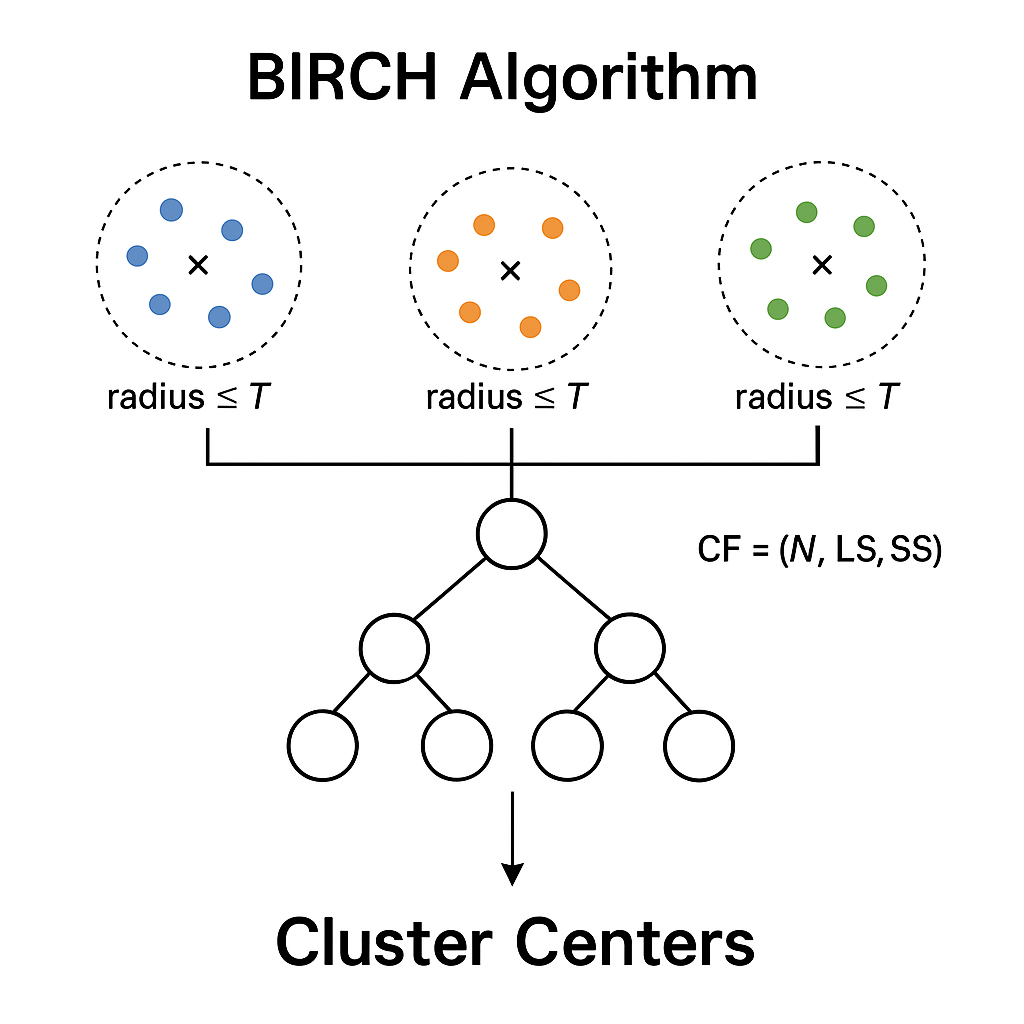


**The Chat**

https://chatgpt.com/c/68380a27-b8e4-8012-91ae-1b0c4348914f


### Normalize price for Birch threshold scaling (Custom Min-Max)

In [29]:
# === STEP 2: Normalize price for Birch threshold scaling ===
normalized = (prices - prices.min()) / (prices.max() - prices.min())
X = normalized.reshape(-1, 1)

# === STEP 3: Run BIRCH clustering ===
model = Birch(threshold=0.09, branching_factor=500, n_clusters=None)
model.fit(X)
labels = model.predict(X)
centers = model.subcluster_centers_.flatten()

# === STEP 4: Organize results in a DataFrame ===
df = pd.DataFrame({
    "Date": dates,
    "Price": prices,
    "Normalized": normalized,
    "Cluster": labels
})
df

,Date,Price,Normalized,Cluster
0,2019-09-23 08:00:00,9930.13,0.049908,0
1,2019-09-23 12:00:00,9930.13,0.049908,0
2,2019-09-23 16:00:00,9930.13,0.049908,0
3,2019-09-23 20:00:00,9930.13,0.049908,0
4,2019-09-24 00:00:00,9930.13,0.049908,0
...,...,...,...,...
12690,2025-07-09 08:00:00,109149.28,0.975286,3
12691,2025-07-09 12:00:00,109213.63,0.975886,3
12692,2025-07-09 16:00:00,111691.60,0.998997,3
12693,2025-07-09 20:00:00,111475.16,0.996978,3


In [30]:
centers

array([0.10429843, 0.50621731, 0.27371744, 0.86795461, 0.74086681])

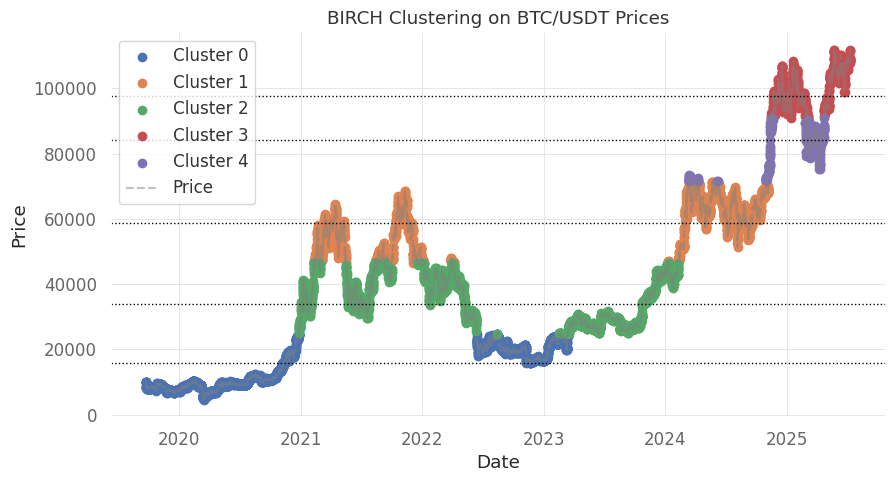

The ATH (last price point) falls into Cluster 3.


In [31]:
# === STEP 5: Plot the clusters and cluster centers ===
plt.figure(figsize=(10, 5))
for label in np.unique(labels):
    mask = labels == label
    plt.scatter(dates[mask], prices[mask], label=f"Cluster {label}")
plt.plot(dates, prices, linestyle="--", alpha=0.5, color="gray", label="Price")

# Plot cluster centers as horizontal lines
for cen in centers:
    price_cen = cen * (prices.max() - prices.min()) + prices.min()
    plt.axhline(price_cen, linestyle=":", linewidth=1, color="black")

# plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title(f"BIRCH Clustering on {INSTRUMENT} Prices")
plt.legend()
# plt.tight_layout()
plt.show()

# === STEP 6: Check cluster of last ATH point ===
last_label = labels[-1]
print(f"The ATH (last price point) falls into Cluster {last_label}.")


### With raw price threshold

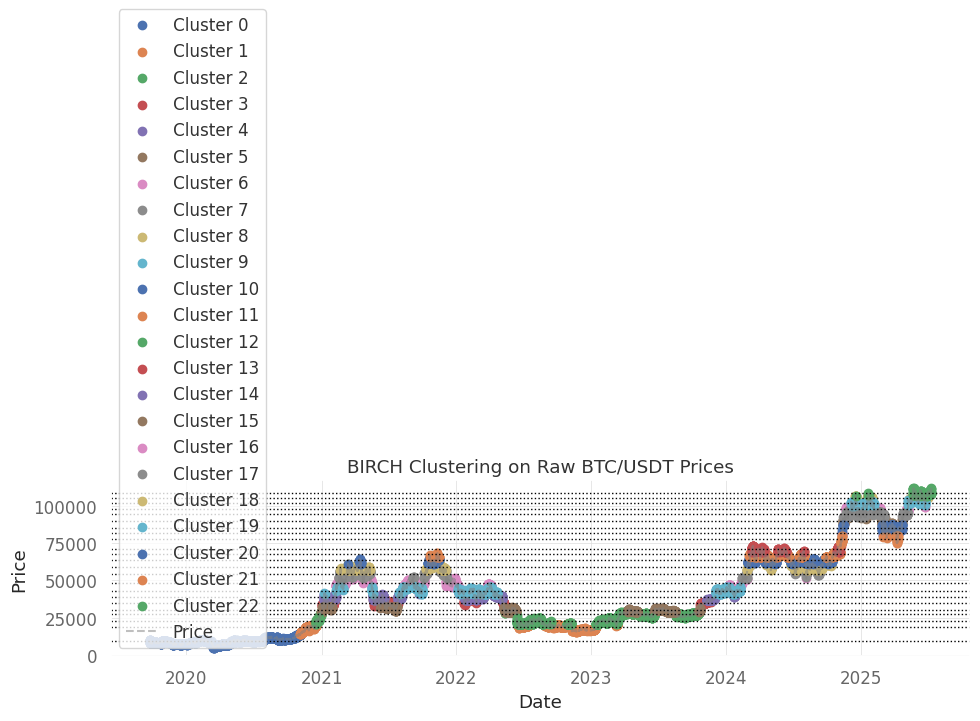

In [32]:
# === STEP 2: Run BIRCH with raw price threshold ===
# Use an absolute price difference for threshold, e.g., $2,000
model = Birch(threshold=2000, branching_factor=500, n_clusters=None)
model.fit(prices.reshape(-1, 1))
labels = model.predict(prices.reshape(-1, 1))
centers = model.subcluster_centers_.flatten()

# === STEP 3: Organize results in a DataFrame ===
df = pd.DataFrame({
    "Date": dates,
    "Price": prices.flatten(),
    "Cluster": labels
})

# === STEP 4: Plot results ===
plt.figure(figsize=(10, 5))
for label in np.unique(labels):
    mask = labels == label
    plt.scatter(dates[mask], prices[mask], label=f"Cluster {label}")
plt.plot(dates, prices, linestyle="--", alpha=0.5, color="gray", label="Price")

# Plot raw-price cluster centers
for cen in centers:
    plt.axhline(cen, linestyle=":", linewidth=1, color="black")

# plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title(f"BIRCH Clustering on Raw {INSTRUMENT} Prices")
plt.legend()
plt.tight_layout()
plt.show()


### Try price normalization using sklearn's MinMaxScaler

In [33]:
# === STEP 2: Normalize price using MinMaxScaler ===
scaler = MinMaxScaler()
X = scaler.fit_transform(prices.reshape(-1, 1))

# === STEP 3: Run BIRCH clustering ===
model = Birch(threshold=0.05, branching_factor=50, n_clusters=None)
model.fit(X)
labels = model.predict(X)
centers = model.subcluster_centers_.flatten()

# === STEP 4: Denormalize centers for plotting ===
center_prices = scaler.inverse_transform(centers.reshape(-1, 1)).flatten()

# === STEP 5: Prepare DataFrame ===
df = pd.DataFrame({
    "Date": dates,
    "Price": prices,
    "Cluster": labels
})
df

,Date,Price,Cluster
0,2019-09-23 08:00:00,9930.13,0
1,2019-09-23 12:00:00,9930.13,0
2,2019-09-23 16:00:00,9930.13,0
3,2019-09-23 20:00:00,9930.13,0
4,2019-09-24 00:00:00,9930.13,0
...,...,...,...
12690,2025-07-09 08:00:00,109149.28,8
12691,2025-07-09 12:00:00,109213.63,8
12692,2025-07-09 16:00:00,111691.60,8
12693,2025-07-09 20:00:00,111475.16,8


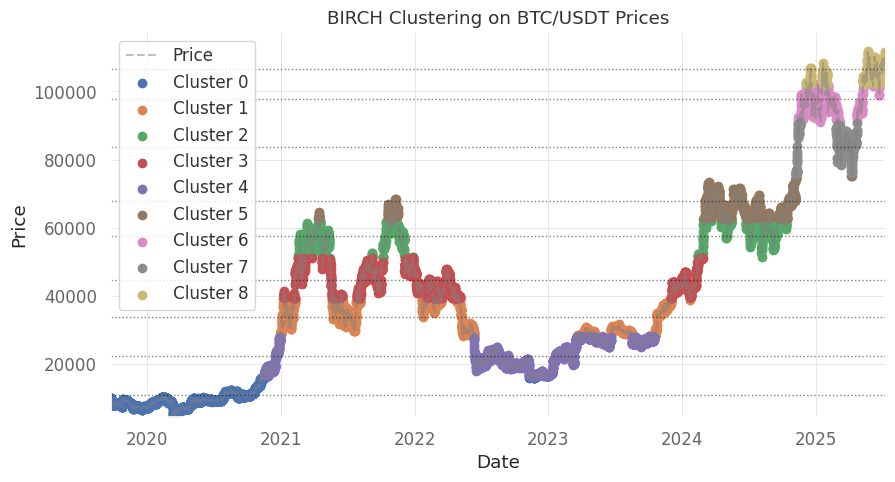

In [34]:
# === STEP 6: Create static plot ===
fig, ax = plt.subplots(figsize=(10, 5))

ax.set_xlim(dates.min(), dates.max())
ax.set_ylim(prices.min() * 0.95, prices.max() * 1.05)
ax.set_title(f"BIRCH Clustering on {INSTRUMENT} Prices")
ax.set_xlabel("Date")
ax.set_ylabel("Price")

# Plot price path
ax.plot(dates, prices, linestyle="--", alpha=0.5, color="gray", label="Price")

# Plot clustered points
for label in np.unique(labels):
    mask = labels == label
    ax.scatter(dates[mask], prices[mask], label=f"Cluster {label}")

# Draw support/resistance zones
for cen in center_prices:
    ax.axhline(cen, linestyle=":", linewidth=1, color="black", alpha=0.5)

ax.legend(loc="upper left")
plt.show()

### Use OHLCV Data

Use Mid Prices => (high + low) / 2

Try:

- HLC3 => (high + low + close) / 3

In [35]:
# === Normalize mid prices ===
mid_prices = ((ohlcv["high"] + ohlcv["low"]) / 2).values.reshape(-1, 1)
scaler = MinMaxScaler()
X = scaler.fit_transform(mid_prices)

# === Apply BIRCH clustering ===
model = Birch(threshold=0.05, branching_factor=500, n_clusters=None)
model.fit(X)
labels = model.predict(X)

In [36]:
# model.n_clusters
model.subcluster_labels_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [37]:
model.subcluster_centers_

array([[0.05952764],
       [0.27397921],
       [0.49605535],
       [0.37330114],
       [0.16530288],
       [0.59060291],
       [0.89546499],
       [0.74576337],
       [0.69303588],
       [0.98054343]])

In [38]:
# # Access the micro-clusters
# micro_clusters = model.subcluster_centers_

# # Get the count of points in each micro-cluster
# for i, micro_cluster in enumerate(micro_clusters):
#     count = micro_cluster.n_samples
#     print(f"Micro-cluster {i+1}: {count} points")

In [39]:
# 4) Retrieve subcluster centers and label mapping
centers_scaled = model.subcluster_centers_
centers = scaler.inverse_transform(centers_scaled).flatten()
label_map = model.subcluster_labels_

label_map

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [40]:
# 5) Map each predicted label to corresponding cluster center
# label_map[i] tells you the label for subcluster_centers_[i]
# So: for each predicted label in labels, find the corresponding center
mapped_centers = np.array([centers[label_map == lbl][0] for lbl in labels])
mapped_centers

array([ 10948.40859621,  10948.40859621,  10948.40859621, ...,
       109399.18045455, 109399.18045455, 109399.18045455])

In [41]:
# === Store cluster labels and calculate support/resistance ===
ohlcv["Cluster"] = labels
cluster_supports = ohlcv.groupby("Cluster")["low"].min().values
cluster_resistances = ohlcv.groupby("Cluster")["high"].max().values

In [42]:
cluster_supports

array([  3649.04,  27467.71,  47913.84,  37949.26,  16217.12,  58618.  ,
        91122.76,  28259.32,  72668.27, 101578.01])

In [43]:
cluster_resistances

array([ 16951.5 ,  41744.48,  64363.48,  52590.43,  28861.27,  74000.  ,
       106943.23, 138070.  ,  82909.93, 111945.48])

In [44]:
def find_birch_sr_zones(df, threshold=0.05, branching_factor=500):
    """
    Applies BIRCH clustering to find potential support and resistance zones
    based on mid-prices.

    Args:
        df (pd.DataFrame): DataFrame containing OHLCV data with 'high' and 'low' columns.
        threshold (float): The maximum radius of a sub-cluster.
        branching_factor (int): The maximum number of children of a CF node.

    Returns:
        tuple: A tuple containing:
            - cluster_supports (np.ndarray): Array of support price levels.
            - cluster_resistances (np.ndarray): Array of resistance price levels.
            - df (pd.DataFrame): The original DataFrame with an added 'Cluster' column.
    """
    # === Normalize mid prices ===
    mid_prices = ((df["high"] + df["low"]) / 2).values.reshape(-1, 1)
    scaler = MinMaxScaler()
    X = scaler.fit_transform(mid_prices)

    # === Apply BIRCH clustering ===
    model = Birch(threshold=threshold, branching_factor=branching_factor, n_clusters=None)
    model.fit(X)
    labels = model.predict(X)

    # 4) Retrieve subcluster centers and label mapping
    centers_scaled = model.subcluster_centers_
    centers = scaler.inverse_transform(centers_scaled).flatten()
    label_map = model.subcluster_labels_

    # 5) Map each predicted label to corresponding cluster center
    # mapped_centers = np.array([centers[label_map == lbl][0] for lbl in labels]) # This line is not used in the original code for calculating S/R

    # === Store cluster labels and calculate support/resistance ===
    df_with_clusters = df.copy()
    df_with_clusters["Cluster"] = labels
    cluster_supports = df_with_clusters.groupby("Cluster")["low"].min().values
    cluster_resistances = df_with_clusters.groupby("Cluster")["high"].max().values

    return cluster_supports, cluster_resistances, df_with_clusters

# Example usage
cluster_supports, cluster_resistances, ohlcv_with_clusters = find_birch_sr_zones(ohlcv)

In [45]:
cluster_supports

array([  3649.04,  27467.71,  47913.84,  37949.26,  16217.12,  58618.  ,
        91122.76,  28259.32,  72668.27, 101578.01])

In [46]:
cluster_resistances

array([ 16951.5 ,  41744.48,  64363.48,  52590.43,  28861.27,  74000.  ,
       106943.23, 138070.  ,  82909.93, 111945.48])

In [47]:
ohlcv_with_clusters

,timestamp,open,high,low,close,volume,Cluster
0,2019-09-23 08:00:00,9930.13,9930.13,9930.13,9930.13,0.00100,0
1,2019-09-23 12:00:00,9930.13,9930.13,9930.13,9930.13,0.00000,0
2,2019-09-23 16:00:00,9930.13,9930.13,9930.13,9930.13,0.00000,0
3,2019-09-23 20:00:00,9930.13,9930.13,9930.13,9930.13,0.00000,0
4,2019-09-24 00:00:00,9930.13,9930.13,9930.13,9930.13,0.00000,0
...,...,...,...,...,...,...,...
12690,2025-07-09 08:00:00,108803.57,109300.00,108596.61,109149.28,4.63964,9
12691,2025-07-09 12:00:00,109058.68,109837.75,108569.34,109213.63,15.19159,9
12692,2025-07-09 16:00:00,109213.57,111932.25,109100.00,111691.60,18.50570,9
12693,2025-07-09 20:00:00,111900.86,111934.84,110620.54,111475.16,9.89051,9


In [48]:

def plot_ohlc_with_zones(df, instrument, timeframe, supports, resistances, reset_index=False):
    """
    Plots OHLC bars and overlays support and resistance zones.

    Args:
        df (pd.DataFrame): DataFrame containing OHLCV data with 'timestamp',
                           'open', 'high', 'low', and 'close' columns.
        instrument (str): The trading instrument (e.g., "SOL/USDT").
        timeframe (str): The data timeframe (e.g., "4h").
        supports (list): A list of support price levels.
        resistances (list): A list of resistance price levels.
    """
    if reset_index:
        df.reset_index(inplace=True)

    fig, ax = plt.subplots(figsize=(10, 5))

    ax.set_xlim(df["timestamp"].min(), df["timestamp"].max())
    ax.set_ylim(df["low"].min() * 0.95, df["high"].max() * 1.05)
    ax.set_title(f"{instrument} ({timeframe}) Support and Resistance Zones (Clustering)")
    ax.set_xlabel("Timestamp")
    ax.set_ylabel(f"{instrument} Price")

    # Plot OHLC bars
    for i in range(len(df)):
        color = "green" if df["close"][i] >= df["open"][i] else "red"
        ax.plot([df["timestamp"][i], df["timestamp"][i]], [df["low"][i], df["high"][i]], color="black")
        ax.plot([df["timestamp"][i], df["timestamp"][i]], [df["open"][i], df["close"][i]], color=color, linewidth=5)

    # Plot support and resistance
    for support in supports:
        ax.axhline(support, linestyle="--", color="blue", linewidth=1, alpha=0.5, label="Support")
    for resistance in resistances:
        ax.axhline(resistance, linestyle="--", color="orange", linewidth=1, alpha=0.5, label="Resistance")

    # Remove duplicate legend entries
    handles, labels_unique = ax.get_legend_handles_labels()
    by_label = dict(zip(labels_unique, handles))
    ax.legend(by_label.values(), by_label.keys(), loc="upper left")

    plt.show()

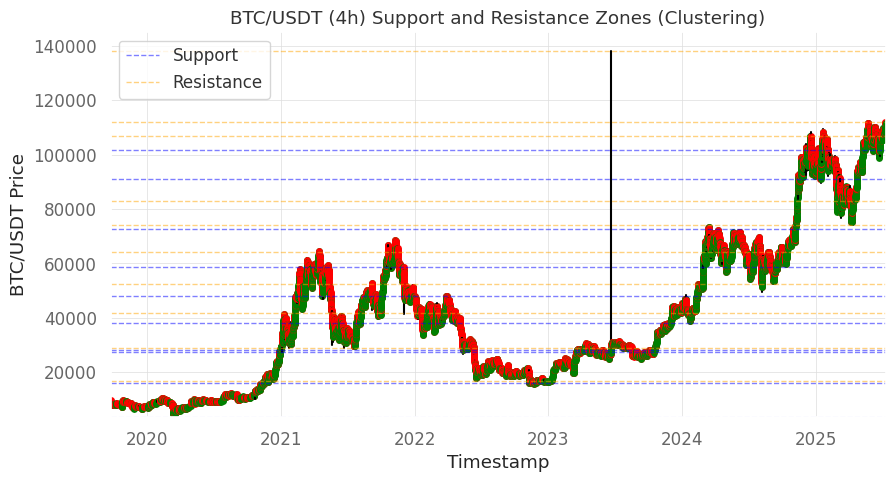

In [49]:
plot_ohlc_with_zones(
    df=ohlcv,
    instrument=INSTRUMENT,
    timeframe=TIMEFRAME,
    supports=cluster_supports,
    resistances=cluster_resistances,
    reset_index=True,
    # sr_zone_pct=0.003,
    # y_pad_pct=0.05,
)


# Advanced Price/Pattern Prediction

with Neural Networks

TODO: Multi-Variate/multi-feature time-series data

In [50]:
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import (
    Layer, Input, Conv1D, LSTM, Bidirectional, Dense, Dropout, Permute, Reshape,
    Multiply, Attention, AdditiveAttention, BatchNormalization, LayerNormalization, Concatenate, Lambda,
    MultiHeadAttention
)
from keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau,
    TensorBoard, CSVLogger, LearningRateScheduler
)

import mplfinance as mpf
import matplotlib.dates as mpl_dates


# Check TensorFlow version
print("TensorFlow Version: ", tf.__version__)


TensorFlow Version:  2.18.0


## Load Data

In [51]:

def load_nn_data(_type="ccxt", symbol="DX-Y.NYB", timeframe="1d", start='2020-01-01', end='2024-01-01', **kwargs):
    """
    Loads and prepares data for the neural network based on source type (ccxt or yahoo).

    Args:
        _type (str): Source of data ('ccxt' or 'yahoo').
        symbol (str): The symbol to load data for.
        timeframe (str): Timeframe for OHLCV data (used for ccxt).
        start (str): ISO string of the start datetime.
        end (str): ISO string of the end datetime.

    Returns:
        pd.DataFrame: Sliced and timezone-consistent data, or an empty DataFrame on error.
    """

    def slice_and_localize(df, source, start, end):
        try:
            if source == "yahoo":
                df.index = pd.to_datetime(df.index).tz_localize('UTC')
            return df # .loc[start:end]
        except KeyError:
            print(f"⚠️ Warning: Date range {start} to {end} not found in {source.upper()} data.")
        except Exception as e:
            print(f"❌ Error processing {source.upper()} data: {e}")
        return pd.DataFrame()

    if _type == "ccxt":
        try:
            exchange_id = kwargs.get("exchange_id", "coinbase")
            ohlcv = get_ccxt_data(
                exchange_id=exchange_id,
                symbol=symbol,
                timeframe=timeframe,
                start_date=start,
                end_date=end
            )
            if not ohlcv.empty:
                return slice_and_localize(ohlcv, "ccxt", start, end)
            else:
                print("❌ Error: CCXT data is empty.")
        except Exception as e:
            print(f"❌ Error loading CCXT data: {e}")

    elif _type == "yahoo":
        try:
            # Step 1: Fetch and store
            fetch_and_save_yahoo_data([symbol], start_date, end_date, timeframe, data_dir)
            data = get_yahoo_data(symbol, timeframe=interval, data_dir=data_dir, start_date=start_date, end_date=end_date)
            if not data.empty:
                data.rename_axis('timestamp', inplace=True)
                return slice_and_localize(data, "yahoo", start, end)
            else:
                print(f"❌ Error: Yahoo data could not be loaded for {symbol}.")
        except Exception as e:
            print(f"❌ Error fetching Yahoo data: {e}")

    else:
        print(f"❌ Error: Unsupported data type '{_type}'. Use 'ccxt' or 'yahoo'.")

    return pd.DataFrame()

In [52]:
price_pred_symbol = "BTC/USDT" # "DX-Y.NYB" | SOL-USD | BTC/USDT
price_pred_timeframe = "4h" # "1d" | 4h | 15m
start="2019-06-01T00:00:00Z"
# train_test_end="2025-06-01T00:00:00Z"
_advpp_data = load_nn_data("ccxt", symbol=price_pred_symbol, timeframe=price_pred_timeframe, start=start, end=year_month_day_hour_min_sec_z, exchange_id=EXCHANGE_ID)
_advpp_data

,timestamp,open,high,low,close,volume
0,2019-09-23 08:00:00,9930.13,9930.13,9930.13,9930.13,0.00100
1,2019-09-23 12:00:00,9930.13,9930.13,9930.13,9930.13,0.00000
2,2019-09-23 16:00:00,9930.13,9930.13,9930.13,9930.13,0.00000
3,2019-09-23 20:00:00,9930.13,9930.13,9930.13,9930.13,0.00000
4,2019-09-24 00:00:00,9930.13,9930.13,9930.13,9930.13,0.00000
...,...,...,...,...,...,...
12690,2025-07-09 08:00:00,108803.57,109300.00,108596.61,109149.28,4.63964
12691,2025-07-09 12:00:00,109058.68,109837.75,108569.34,109213.63,15.19159
12692,2025-07-09 16:00:00,109213.57,111932.25,109100.00,111691.60,18.50570
12693,2025-07-09 20:00:00,111900.86,111934.84,110620.54,111475.16,9.89051


### Add Clustering (S/R)

In [53]:
cluster_supports, cluster_resistances, advpp_data = find_birch_sr_zones(_advpp_data)
advpp_data.head()

,timestamp,open,high,low,close,volume,Cluster
0,2019-09-23 08:00:00,9930.13,9930.13,9930.13,9930.13,0.001,0
1,2019-09-23 12:00:00,9930.13,9930.13,9930.13,9930.13,0.000,0
2,2019-09-23 16:00:00,9930.13,9930.13,9930.13,9930.13,0.000,0
3,2019-09-23 20:00:00,9930.13,9930.13,9930.13,9930.13,0.000,0
4,2019-09-24 00:00:00,9930.13,9930.13,9930.13,9930.13,0.000,0


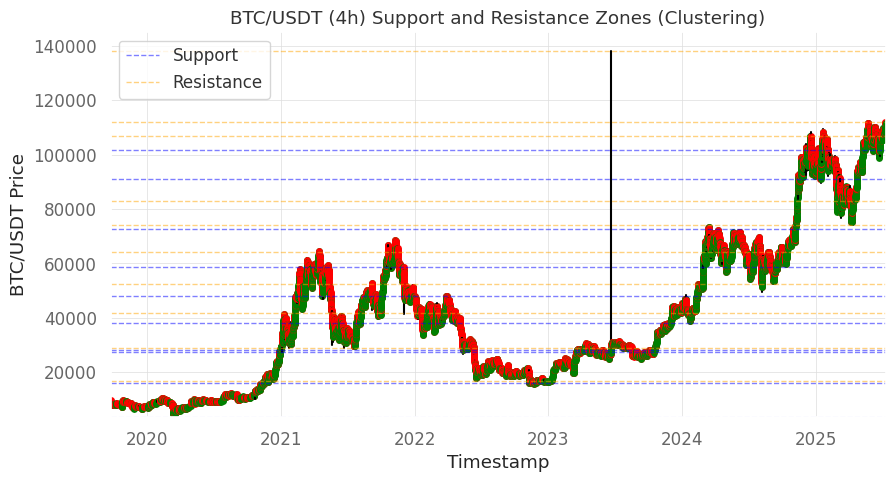

In [54]:
plot_ohlc_with_zones(advpp_data, price_pred_symbol, price_pred_timeframe, cluster_supports, cluster_resistances, reset_index=True)


### Add ZLEMA

compute multiple ZLEMA periods (e.g., 20, 50, 100) based on the model's needs.


**Why ZLEMA Helps:**

- It reduces lag compared to EMA, enabling your network to detect trend changes sooner.

- The smoother trend signal enhances both regression accuracy and classification consistency when used with threshold logic.



Optionally, derive additional features:

- zlema_gamma = (price - zlema) / zlema

- zlema_slope = zlema.diff()

In [55]:
import pandas as pd

# def compute_zlema(price: pd.Series, period: int) -> pd.Series:
#     lag = (period - 1) // 2
#     ema_data = price + (price - price.shift(lag))
#     zlema = ema_data.ewm(span=period, adjust=False).mean()
#     return zlema

def compute_zlema(price: pd.Series, period: int) -> pd.Series:
    lag = (period - 1) // 2
    ema_data = price + (price - price.shift(lag))
    return ema_data.ewm(span=period, adjust=False).mean()

def compute_zlema_np(price: np.ndarray, period: int) -> np.ndarray:
    lag = (period - 1) // 2
    ema_data = np.empty_like(price)
    ema_data[:lag] = price[:lag]
    ema_data[lag:] = price[lag:] + (price[lag:] - price[:-lag])
    alpha = 2 / (period + 1)
    z = np.empty_like(price)
    z[0] = price[0]
    for t in range(1, len(price)):
        z[t] = alpha * ema_data[t] + (1 - alpha) * z[t - 1]
    return z


# advpp_data['zlema_20'] = compute_zlema(advpp_data['close'], 20)
# advpp_data['zlema_50'] = compute_zlema(advpp_data['close'], 50)
# Add as feature columns
# feature_cols = ['open','high','low','close','volume','zlema_20','zlema_50', ...]
# X = df[feature_cols].dropna().values  # Aligns data

### Add PDH/PDL/PDC

In [56]:
# Intraday Version

# # Ensure your datetime column is in datetime format
# advpp_data['timestamp'] = pd.to_datetime(advpp_data['timestamp'])
# advpp_data.set_index('timestamp', inplace=True)

# # Extract date only
# advpp_data['date'] = advpp_data.index.date

# # Compute daily high/low
# # Calculate previous day high, low, and close
# daily_ohlc = advpp_data.groupby('date').agg({
#     'high': 'max',
#     'low': 'min',
#     'close': 'last',
# }).shift(1)  # shift to get previous day values

# daily_ohlc.columns = ['pdh', 'pdl', 'pdc']  # rename

# # Join back to main DataFrame using date
# advpp_data = advpp_data.join(daily_high, on='date')
# advpp_data = advpp_data.join(daily_low, on='date')

# # Drop helper date column if not needed
# advpp_data.drop(columns='date', inplace=True)


#  Daily TF Version

# advpp_data['pdh'] = advpp_data['high'].shift(1)
# advpp_data['pdl'] = advpp_data['low'].shift(1)
# advpp_data['pdc'] = advpp_data['close'].shift(1)

# # Join back to intraday data
# advpp_data = advpp_data.join(daily_ohlc, on='date')

# # Compute proximity features
# advpp_data['close_to_pdh'] = (advpp_data['close'] - advpp_data['pdh']) / advpp_data['pdh']
# advpp_data['close_to_pdl'] = (advpp_data['close'] - advpp_data['pdl']) / advpp_data['pdl']
# advpp_data['close_to_pdc'] = (advpp_data['close'] - advpp_data['pdc']) / advpp_data['pdc']


### Sessions (Asia, London, NY)

In [57]:
# import pandas as pd

# # Ensure timestamp is parsed
# advpp_data['timestamp'] = pd.to_datetime(advpp_data['timestamp'])

# # Extract hour from timestamp
# advpp_data['hour'] = advpp_data['timestamp'].dt.hour

# # Define session assignment function
# def get_session(hour):
#     if 0 <= hour < 8:
#         return 'Asia'
#     elif 8 <= hour < 16:
#         return 'London'
#     else:
#         return 'New_York'

# # Assign session label
# advpp_data['session'] = advpp_data['hour'].apply(get_session)

# # One-hot encode session
# session_dummies = pd.get_dummies(advpp_data['session'], prefix='session')
# advpp_data = pd.concat([advpp_data, session_dummies], axis=1)

# # Optional cleanup
# advpp_data.drop(columns=['hour', 'session'], inplace=True)


### Compact Feature Pipeline

| Feature                           | Description                                  |
| --------------------------------- | -------------------------------------------- |
| `zlema_20`, `zlema_50`            | Zero-lag EMAs for trend                      |
| `zlema_cross`                     | Signal: 1 if zlema\_20 > zlema\_50           |
| `zlema_slope`                     | ZLEMA slope (momentum)                       |
| `pdh`, `pdl`, `pdc`               | Previous day OHLC                            |
| `close_to_*`                      | Relative position to prior session structure |
| `is_weekend`, `weekday_*`         | Time-based structural signals                |
| `session_*`                       | One-hot encoded session info                 |
| `session_return`, `session_range` | Intraday movement range                      |
| `session_volatility`              | Std of log returns per session               |
| `session_entropy`                 | Entropy of up/down movement patterns         |






In [58]:
from scipy.stats import entropy

def feature_pipeline(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)

    # ZLEMA
    df['zlema_20'] = compute_zlema(df['close'], 20)
    df['zlema_50'] = compute_zlema(df['close'], 50)

    # ZLEMA-based signal
    df['zlema_cross'] = np.where(df['zlema_20'] > df['zlema_50'], 1, -1)
    df['zlema_slope'] = df['zlema_20'].diff()

    # Returns and percent changes
    # df['pct_change'] = df['close'].pct_change()
    for lag in range(1, 6):
      df[f'return_lag_{lag}'] = df['close'].pct_change().shift(lag)

    # Previous Day OHLC
    df['date'] = df.index.date
    ohlc = df.groupby('date').agg({'high': 'max', 'low': 'min', 'close': 'last'}).shift(1)
    ohlc.columns = ['pdh', 'pdl', 'pdc']
    df = df.join(ohlc, on='date')

    df['close_to_pdh'] = (df['close'] - df['pdh']) / df['pdh']
    df['close_to_pdl'] = (df['close'] - df['pdl']) / df['pdl']
    df['close_to_pdc'] = (df['close'] - df['pdc']) / df['pdc']

    # Weekend / Weekday
    df['weekday'] = df.index.weekday
    df['is_weekend'] = (df['weekday'] >= 5).astype(int)
    weekday_dummies = pd.get_dummies(df['weekday'], prefix='weekday')
    df = pd.concat([df, weekday_dummies], axis=1)

    # Session classification
    df['hour'] = df.index.hour
    df['session'] = df['hour'].apply(lambda h: 'Asia' if h < 8 else 'London' if h < 16 else 'New_York')
    df['session_date'] = df.index.date.astype(str)
    df['session_id'] = df['session_date'] + "_" + df['session']

    # Session stats
    session_stats = df.groupby('session_id').agg({
        'open': 'first', 'close': 'last', 'high': 'max', 'low': 'min', 'volume': 'sum'
    })

    session_stats['session_return'] = (session_stats['close'] - session_stats['open']) / session_stats['open']
    session_stats['session_range'] = (session_stats['high'] - session_stats['low']) / session_stats['open']

    # Session volatility (std of log returns)
    log_ret = np.log1p(df['close'].pct_change().shift(1))
    df['log_ret'] = log_ret
    session_vol = df.groupby('session_id')['log_ret'].std().rename('session_volatility')

    # Session entropy of return sign
    def calc_entropy(series):
        counts = series.apply(lambda x: 1 if x > 0 else 0).value_counts(normalize=True)
        return entropy(counts, base=2) if len(counts) > 1 else 0.0
    session_entropy = df.groupby('session_id')['log_ret'].apply(calc_entropy).rename('session_entropy')

    # Merge session stats
    df = df.merge(session_stats[['session_return', 'session_range']], left_on='session_id', right_index=True, how='left')
    df = df.merge(session_vol, left_on='session_id', right_index=True, how='left')
    df = df.merge(session_entropy, left_on='session_id', right_index=True, how='left')

    # Session one-hot
    session_dummies = pd.get_dummies(df['session'], prefix='session')
    df = pd.concat([df, session_dummies], axis=1)

    # Cleanup
    df.drop(columns=['weekday', 'hour', 'session', 'session_date', 'session_id', 'date', 'log_ret'], inplace=True)

    return df


In [59]:
advpp_data = feature_pipeline(advpp_data)
advpp_data.dropna(inplace=True)

if 'index' in advpp_data.columns:
  advpp_data.drop(columns=['index'], inplace=True)

## Preprocess

Separate the data into train and test sets for before scaling, to minimize forward looking bias

In [60]:
target_column = 'close'  # or 'close'/'zlema_20' if included

# Display the first few rows and the shape to verify
advpp_data.shape

(12664, 36)

In [61]:
# Checking for missing values
advpp_data.isnull().sum()

# Filling missing values, if any
# advpp_data.fillna(method='ffill', inplace=True)
advpp_data.ffill(inplace=True)

advpp_data

,open,high,low,close,volume,Cluster,zlema_20,zlema_50,zlema_cross,zlema_slope,...,weekday_4,weekday_5,weekday_6,session_return,session_range,session_volatility,session_entropy,session_Asia,session_London,session_New_York
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-09-27 08:00:00,8064.20,8120.92,7971.32,7988.61,1.727980,0,7440.077591,6047.090000,1,10.722359,...,True,False,False,-0.011659,0.032531,0.010894,1.0,False,True,False
2019-09-27 12:00:00,7982.71,8084.33,7858.58,7970.18,5.415892,0,7452.628296,6045.644510,1,12.550706,...,True,False,False,-0.011659,0.032531,0.010894,1.0,False,True,False
2019-09-27 16:00:00,7980.22,8056.82,7954.17,7999.85,9.976614,0,7468.539887,6046.582764,1,15.911591,...,True,False,False,0.024875,0.038318,0.004261,1.0,False,False,True
2019-09-27 20:00:00,7983.20,8259.96,7983.20,8178.73,15.699279,0,7515.141803,6061.514028,1,46.601916,...,True,False,False,0.024875,0.038318,0.004261,1.0,False,False,True
2019-09-28 00:00:00,8199.40,8201.59,8128.64,8163.03,2.843224,0,7598.219726,6074.628380,1,83.077924,...,False,True,False,0.000963,0.009593,0.016996,1.0,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-09 04:00:00,108449.42,109078.00,108343.24,108719.31,2.328720,9,108566.220360,108731.630413,-1,80.201015,...,False,False,False,-0.001543,0.007120,0.004843,1.0,True,False,False
2025-07-09 08:00:00,108803.57,109300.00,108596.61,109149.28,4.639640,9,108710.622231,108788.027651,-1,144.401870,...,False,False,False,0.003769,0.011658,0.001041,0.0,False,True,False
2025-07-09 12:00:00,109058.68,109837.75,108569.34,109213.63,15.191590,9,108886.485828,108850.714410,1,175.863597,...,False,False,False,0.003769,0.011658,0.001041,0.0,False,True,False


### Split

In [62]:

def split_train_test(data: pd.DataFrame, split_ratio=0.8, target_column='close'):
    """
    Splits multi-feature data into training and testing sets, extracting the specified target column.

    Args:
        data (pd.DataFrame): Input DataFrame with multiple features including target_column.
        split_ratio (float): Proportion of data to use for training (default: 0.8).
        target_column (str): Name of the column to extract as the supervised target (default: 'close').

    Returns:
        tuple: (train_X, test_X, train_y, test_y)
            - train_X: np.ndarray, shape (n_train, n_features)
            - test_X: np.ndarray, shape (n_test, n_features)
            - train_y: np.ndarray, shape (n_train, 1)
            - test_y: np.ndarray, shape (n_test, 1)
    """
    train_size = int(len(data) * split_ratio)
    train = data.iloc[:train_size].copy()
    test = data.iloc[train_size:].copy()

    train_X = train.drop(columns=[target_column]).values
    test_X = test.drop(columns=[target_column]).values

    train_y = train[target_column].values.reshape(-1, 1)
    test_y = test[target_column].values.reshape(-1, 1)

    return train_X, test_X, train_y, test_y


train_X, test_X, train_y, test_y = split_train_test(advpp_data, target_column=target_column)


### Scale

In [63]:
from sklearn.preprocessing import MinMaxScaler

def scale_data(
    train_X,
    test_X=None,
    full_X=None,
    train_y=None,
    test_y=None,
    full_y=None,
    scale_target=False,
    feature_range=(0, 1)
):
    """
    Scales multi-feature inputs (X) and optionally target outputs (y) using MinMaxScaler.
    Preserves DataFrame outputs with column names if inputs are DataFrames.

    Returns:
        dict: {
            'X_scaler': MinMaxScaler object,
            'train_X_scaled': pd.DataFrame or np.ndarray,
            'test_X_scaled': pd.DataFrame or np.ndarray,
            'full_X_scaled': pd.DataFrame or np.ndarray,
            'y_scaler': MinMaxScaler object or None,
            'train_y_scaled': pd.Series or np.ndarray,
            'test_y_scaled': pd.Series or np.ndarray,
            'full_y_scaled': pd.Series or np.ndarray
        }
    """
    def to_np(x):
        if isinstance(x, (pd.DataFrame, pd.Series)):
            return x.values.reshape(-1, 1) if x.ndim == 1 else x
        return x

    def to_named(x_scaled, ref):
        if isinstance(ref, pd.DataFrame):
            return pd.DataFrame(x_scaled, columns=ref.columns, index=ref.index)
        elif isinstance(ref, pd.Series):
            return pd.Series(x_scaled.flatten(), name=ref.name, index=ref.index)
        return x_scaled

    # Store column/index info
    ref_train_X, ref_test_X, ref_full_X = train_X, test_X, full_X
    ref_train_y, ref_test_y, ref_full_y = train_y, test_y, full_y

    train_X = to_np(train_X)
    test_X = to_np(test_X)
    full_X = to_np(full_X)

    X_scaler = MinMaxScaler(feature_range=feature_range)
    train_X_scaled = X_scaler.fit_transform(train_X)
    test_X_scaled = X_scaler.transform(test_X) if test_X is not None else None
    full_X_scaled = X_scaler.fit_transform(full_X) if full_X is not None else None

    # Restore DataFrame structure
    train_X_scaled = to_named(train_X_scaled, ref_train_X)
    test_X_scaled = to_named(test_X_scaled, ref_test_X) if test_X is not None else None
    full_X_scaled = to_named(full_X_scaled, ref_full_X) if full_X is not None else None

    # Optional target scaling
    y_scaler = None
    train_y_scaled = test_y_scaled = full_y_scaled = None

    if scale_target and train_y is not None:
        train_y = to_np(train_y)
        test_y = to_np(test_y)
        full_y = to_np(full_y)

        y_scaler = MinMaxScaler(feature_range=feature_range)
        train_y_scaled = y_scaler.fit_transform(train_y)
        test_y_scaled = y_scaler.transform(test_y) if test_y is not None else None
        full_y_scaled = y_scaler.fit_transform(full_y) if full_y is not None else None

        # Restore target structure
        train_y_scaled = to_named(train_y_scaled, ref_train_y)
        test_y_scaled = to_named(test_y_scaled, ref_test_y) if test_y is not None else None
        full_y_scaled = to_named(full_y_scaled, ref_full_y) if full_y is not None else None

    return {
        'X_scaler': X_scaler,
        'train_X_scaled': train_X_scaled,
        'test_X_scaled': test_X_scaled,
        'full_X_scaled': full_X_scaled,
        'y_scaler': y_scaler,
        'train_y_scaled': train_y_scaled,
        'test_y_scaled': test_y_scaled,
        'full_y_scaled': full_y_scaled
    }



scaling_results = scale_data(
    train_X, test_X=test_X, full_X=advpp_data.drop(columns=target_column),
    train_y=train_y, test_y=test_y, full_y=advpp_data[target_column],
    scale_target=True
)


X_scaler = scaling_results['X_scaler']
train_X = scaling_results['train_X_scaled']
test_X = scaling_results['test_X_scaled']
full_X = scaling_results['full_X_scaled']

y_scaler = scaling_results['y_scaler']
train_y = scaling_results['train_y_scaled']
test_y = scaling_results['test_y_scaled']
full_y = scaling_results['full_y_scaled']


In [64]:
full_X

,open,high,low,volume,Cluster,zlema_20,zlema_50,zlema_cross,zlema_slope,return_lag_1,...,weekday_4,weekday_5,weekday_6,session_return,session_range,session_volatility,session_entropy,session_Asia,session_London,session_New_York
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-09-27 08:00:00,0.032663,0.023936,0.040240,0.000298,0.0,0.023600,0.014063,1.0,0.523776,0.588233,...,1.0,0.0,0.0,0.550959,0.008012,0.052912,1.0,0.0,1.0,0.0
2019-09-27 12:00:00,0.031904,0.023661,0.039190,0.000946,0.0,0.023717,0.014049,1.0,0.524336,0.544390,...,1.0,0.0,0.0,0.550959,0.008012,0.052912,1.0,0.0,1.0,0.0
2019-09-27 16:00:00,0.031881,0.023455,0.040080,0.001747,0.0,0.023865,0.014058,1.0,0.525365,0.564379,...,1.0,0.0,0.0,0.652444,0.009505,0.020692,1.0,0.0,0.0,1.0
2019-09-27 20:00:00,0.031909,0.024981,0.040351,0.002753,0.0,0.024300,0.014199,1.0,0.534763,0.581567,...,1.0,0.0,0.0,0.652444,0.009505,0.020692,1.0,0.0,0.0,1.0
2019-09-28 00:00:00,0.033923,0.024542,0.041705,0.000494,0.0,0.025076,0.014323,1.0,0.545933,0.634695,...,0.0,1.0,0.0,0.586022,0.002094,0.082553,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-09 04:00:00,0.967847,0.782237,0.974690,0.000403,1.0,0.967446,0.982409,0.0,0.545052,0.556887,...,0.0,0.0,0.0,0.579059,0.001455,0.023518,1.0,1.0,0.0,0.0
2025-07-09 08:00:00,0.971146,0.783905,0.977049,0.000809,1.0,0.968794,0.982941,0.0,0.564712,0.578018,...,0.0,0.0,0.0,0.593814,0.002626,0.005053,0.0,0.0,1.0,0.0
2025-07-09 12:00:00,0.973522,0.787944,0.976795,0.002664,1.0,0.970435,0.983532,1.0,0.574346,0.582229,...,0.0,0.0,0.0,0.593814,0.002626,0.005053,0.0,0.0,1.0,0.0


In [65]:
full_y

,close
timestamp,
2019-09-27 08:00:00,0.031800
2019-09-27 12:00:00,0.031628
2019-09-27 16:00:00,0.031905
2019-09-27 20:00:00,0.033573
2019-09-28 00:00:00,0.033427
...,...
2025-07-09 04:00:00,0.971276
2025-07-09 08:00:00,0.975286
2025-07-09 12:00:00,0.975886


### Generate input sequences

In [66]:
import numpy as np
import pandas as pd

def generate_lookback_sequences(train_data_scaled, test_data_scaled, lookback=60, target_column=0):
    """
    Generates lookback sequences for LSTM/RNN models from multi-feature scaled data.

    Args:
        train_data_scaled (pd.DataFrame or np.ndarray): Scaled training data, shape (n_train, n_features)
        test_data_scaled (pd.DataFrame or np.ndarray): Scaled test data, shape (n_test, n_features)
        lookback (int): Number of past time steps to include in each input sequence.
        target_column (int or str): Column index (int) or name (str) to use as target (default: 0).

    Returns:
        tuple:
            - X_train: np.ndarray, shape (n_train_samples, lookback, n_features)
            - y_train: np.ndarray, shape (n_train_samples,)
            - X_test: np.ndarray, shape (n_test_samples, lookback, n_features)
            - y_test: np.ndarray, shape (n_test_samples,)
    """
    # Convert to numpy if DataFrame, keep column names for indexing if needed
    train_df = train_data_scaled if isinstance(train_data_scaled, pd.DataFrame) else pd.DataFrame(train_data_scaled)
    test_df = test_data_scaled if isinstance(test_data_scaled, pd.DataFrame) else pd.DataFrame(test_data_scaled)

    # Resolve target column index if name is passed
    if isinstance(target_column, str):
        target_idx = train_df.columns.get_loc(target_column)
    else:
        target_idx = target_column

    X_train, y_train = [], []
    for i in range(lookback, len(train_df)):
        X_train.append(train_df.iloc[i - lookback:i].values)
        y_train.append(train_df.iloc[i, target_idx])

    X_test, y_test = [], []
    if len(test_df) >= lookback:
        for i in range(lookback, len(test_df)):
            X_test.append(test_df.iloc[i - lookback:i].values)
            y_test.append(test_df.iloc[i, target_idx])
    else:
        print(f"⚠️ Not enough test data to form sequences of length {lookback}")
        return np.array([]), np.array([]), np.array([]), np.array([])

    return (
        np.array(X_train),
        np.array(y_train),
        np.array(X_test),
        np.array(y_test)
    )


In [67]:
def array_to_df(array, columns, index=None):
    """Convert scaled numpy array back to DataFrame with correct column names."""
    return pd.DataFrame(array, columns=columns, index=index)


feature_cols = train_X.columns if isinstance(train_X, pd.DataFrame) else advpp_data.drop(columns='close').columns

train_X_df = array_to_df(train_X, columns=feature_cols)
test_X_df = array_to_df(test_X, columns=feature_cols)
train_X_df[target_column] = train_y
test_X_df[target_column] = test_y

train_X_df

,open,high,low,volume,Cluster,zlema_20,zlema_50,zlema_cross,zlema_slope,return_lag_1,...,weekday_5,weekday_6,session_return,session_range,session_volatility,session_entropy,session_Asia,session_London,session_New_York,close
0,0.050993,0.023936,0.062428,0.000292,0.000,0.036913,0.021625,1.0,0.563021,0.588233,...,0.0,0.0,0.550959,0.008012,0.052902,1.0,0.0,1.0,0.0,0.049604
1,0.049808,0.023661,0.060800,0.000940,0.000,0.037097,0.021604,1.0,0.563623,0.544390,...,0.0,0.0,0.550959,0.008012,0.052902,1.0,0.0,1.0,0.0,0.049336
2,0.049772,0.023455,0.062181,0.001741,0.000,0.037329,0.021618,1.0,0.564730,0.564379,...,0.0,0.0,0.652444,0.009505,0.020682,1.0,0.0,0.0,1.0,0.049767
3,0.049815,0.024981,0.062600,0.002747,0.000,0.038009,0.021834,1.0,0.574832,0.581567,...,0.0,0.0,0.652444,0.009505,0.020682,1.0,0.0,0.0,1.0,0.052370
4,0.052960,0.024542,0.064701,0.000488,0.000,0.039222,0.022025,1.0,0.586839,0.634695,...,1.0,0.0,0.586022,0.002094,0.082544,1.0,1.0,0.0,0.0,0.052141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10126,0.827345,0.426903,0.824424,0.001040,0.250,0.819988,0.820809,0.0,0.559780,0.574881,...,0.0,0.0,0.622863,0.006737,0.023132,1.0,1.0,0.0,0.0,0.823229
10127,0.823121,0.431812,0.825457,0.000451,0.250,0.823227,0.822079,1.0,0.632533,0.555710,...,0.0,0.0,0.622863,0.006737,0.023132,1.0,1.0,0.0,0.0,0.840009
10128,0.840717,0.437975,0.847387,0.001922,0.625,0.827862,0.823855,1.0,0.664010,0.624710,...,0.0,0.0,0.611956,0.003449,0.041123,0.0,0.0,1.0,0.0,0.846109
10129,0.845415,0.436891,0.849359,0.002243,0.625,0.832600,0.825245,1.0,0.666311,0.590134,...,0.0,0.0,0.611956,0.003449,0.041123,0.0,0.0,1.0,0.0,0.850014


In [89]:
X_train, y_train, X_test, y_test = generate_lookback_sequences(
    train_X_df, test_X_df, lookback=60, target_column=target_column
)


In [92]:
X_train.shape, X_test.shape

((10071, 60, 36), (2473, 60, 36))

In [91]:
y_train.shape, y_test.shape

((10071,), (2473,))

### Prepare Targets

In [114]:
def create_binary_direction_labels(series: pd.Series | np.ndarray) -> np.ndarray:
    """
    Converts a price series to binary direction labels.

    1 = next price is higher than current (price went up)
    0 = otherwise

    Args:
        series: A Pandas Series or NumPy array of prices (e.g., close or zlema).

    Returns:
        A NumPy array of binary labels: 1 = up, 0 = down or unchanged.
    """
    series = np.asarray(series).flatten()
    direction = np.where(np.roll(series, -1) > series, 1, 0)
    direction = direction[:-1]  # remove last element (can't know "next" direction)
    return direction


def create_binary_labels_with_threshold(series, threshold=0.001):
    delta = np.roll(series, -1) - series
    direction = np.where(delta > threshold, 1, 0)
    return direction[:-1]


def create_ternary_labels_vol_threshold(
    series: pd.Series | np.ndarray,
    window: int = 20,
    multiplier: float = 0.5
) -> np.ndarray:
    """
    Create ternary direction labels using dynamic volatility-based thresholds.

    Args:
        series (pd.Series or np.ndarray): Input price or signal series.
        window (int): Rolling window size for volatility estimation.
        multiplier (float): Threshold = multiplier * rolling std. (adaptive zone size).

    Returns:
        np.ndarray: Array of -1 (down), 0 (neutral), 1 (up) labels.

    Also experiment with:

      multiplier=1.0 → wider neutral zone

      multiplier=0.25 → more sensitivity
    """
    series = pd.Series(series).dropna().reset_index(drop=True)
    returns = series.pct_change()
    volatility = returns.rolling(window=window).std()

    # Compute future returns (price diff from current to next)
    future_ret = (series.shift(-1) - series) / series

    threshold = multiplier * volatility

    labels = np.where(future_ret > threshold, 1,
              np.where(future_ret < -threshold, -1, 0))

    return labels[:-1]  # Drop last due to shift(-1)


In [115]:
y_reg = y_train.flatten()             # scaled or raw
# y_cls = create_binary_direction_labels(y_reg)
y_cls = create_ternary_labels_vol_threshold(y_reg, window=9, multiplier=0.5)

# Align inputs
X_train = X_train[:-1]
y_reg = y_reg[:-1]

# Final structure
y_train_wrp = {
    "regression": y_reg,
    "classification": y_cls
}

y_train_wrp['classification']

array([0, 0, 0, ..., 1, 1, 0])

In [116]:
y_reg = y_test.flatten()             # scaled or raw
# y_cls = create_binary_direction_labels(y_reg)
y_cls = create_ternary_labels_vol_threshold(y_reg, window=9, multiplier=0.5)

# Align inputs
X_test = X_test[:-1]
y_reg = y_reg[:-1]

# Final structure
y_test_wrp = {
    "regression": y_reg,
    "classification": y_cls
}

y_test_wrp['classification']

array([0, 0, 0, ..., 0, 1, 0])

## Build Models

### Without Attention

In [117]:
# from keras.models import Sequential
# from keras.layers import LSTM, Dense, Dropout

# # Model initialization
# model = Sequential()

# # Adding the first LSTM layer
# model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))

# # Adding additional LSTM layers
# model.add(LSTM(units=50, return_sequences=True))
# model.add(LSTM(units=50))

def build_model(input_shape):
    model = Sequential()

    # Adding LSTM layers
    model.add(Input(shape=input_shape))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(LSTM(units=50, return_sequences=False))  # Only the last time step

    # Adding a Dense layer
    model.add(Dense(1))

    # Compiling the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model


# model = build_model(input_shape=(X_train.shape[1], 1))

# Training the model
# history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2)


### With Attention

In [118]:
# Custom feature attention
class FeatureAttention(Layer):
    def __init__(self, units):
        super().__init__()
        self.W = Dense(units)
        self.V = Dense(1)

    def call(self, inputs):
        # inputs: [batch, time, features]
        score = tf.nn.tanh(self.W(inputs))  # -> [batch, time, units]
        score = self.V(score)                # -> [batch, time, 1]
        weights = tf.nn.softmax(score, axis=1)
        return tf.reduce_sum(inputs * weights, axis=1)  # [batch, features]

def build_model_with_dual_attention(input_shape, zlema_length=20):
    inputs = Input(shape=input_shape)  # (time, feat)
    x = inputs

    # Add ZLEMA feature (assumes precomputed)
    # x = Concatenate(...)

    # CNN encoder
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = Dropout(0.2)(x)

    # Bi-LSTM with time-level attention
    x = Bidirectional(LSTM(50, return_sequences=True))(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)

    # Time-attention
    time_weights = tf.keras.layers.Attention()([x, x])
    time_att = tf.reduce_sum(time_weights, axis=1)  # summarized time

    # Feature-attention
    feat_att = FeatureAttention(units=32)(x)

    # Combine both attentions
    concat = tf.keras.layers.Concatenate()([time_att, feat_att])

    # Output heads
    reg = Dense(1, name='regression')(concat)
    cls = Dense(1, activation='sigmoid', name='classification')(concat)

    model = Model(inputs=inputs, outputs=[reg, cls])
    model.compile(optimizer='adam',
                  loss={'regression': 'mse', 'classification': 'binary_crossentropy'},
                  loss_weights={'regression': 0.7, 'classification': 0.3})
    return model


In [119]:
# model = Sequential()

# # Adding LSTM layers with return_sequences=True
# model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
# model.add(LSTM(units=50, return_sequences=True))

# # Adding self-attention mechanism
# # The attention mechanism
# attention = AdditiveAttention(name='attention_weight')
# # Permute and reshape for compatibility
# model.add(Permute((2, 1)))
# model.add(Reshape((-1, X_train.shape[1])))
# attention_result = attention([model.output, model.output])
# multiply_layer = Multiply()([model.output, attention_result])
# # Return to original shape
# model.add(Permute((2, 1)))
# model.add(Reshape((-1, 50)))

# # Adding a Flatten layer before the final Dense layer
# model.add(tf.keras.layers.Flatten())

# # Final Dense layer
# model.add(Dense(1))

def build_model_with_attention_v2(input_shape):
    inputs = Input(shape=input_shape)

    # Adding LSTM layers with Dropout and Batch Normalization
    lstm_out = LSTM(units=50, return_sequences=True)(inputs)
    lstm_out = Dropout(0.2)(lstm_out)
    lstm_out = BatchNormalization()(lstm_out)

    lstm_out = LSTM(units=50, return_sequences=True)(lstm_out)
    lstm_out = Dropout(0.2)(lstm_out)
    lstm_out = BatchNormalization()(lstm_out)

    # The third LSTM layer should also return sequences to be used with attention
    lstm_out = LSTM(units=50, return_sequences=True)(lstm_out)
    lstm_out = Dropout(0.2)(lstm_out)
    lstm_out = BatchNormalization()(lstm_out)

    # Additive Attention mechanism
    # The additive attention layer expects two inputs: query and key/value.
    # Here, we use the output of the last LSTM as both query and key/value.
    attention_output = AdditiveAttention(name='attention_weight')([lstm_out, lstm_out])

    # Multiply the attention output with the LSTM output
    multiply_layer = Multiply()([lstm_out, attention_output])

    # Global average pooling or flattening before the final dense layer
    # Global average pooling can be a good alternative to Flatten for sequence data
    # pooled_output = tf.keras.layers.GlobalAveragePooling1D()(multiply_layer)

    # Alternatively, flatten the output
    flatten_output = tf.keras.layers.Flatten()(multiply_layer)


    # Final Dense layer for prediction (outputting a single value)
    outputs = Dense(1)(flatten_output)

    model = Model(inputs=inputs, outputs=outputs)

    return model

def build_model_with_attention(input_shape):
  inputs = Input(shape=input_shape)

  # Adding LSTM layers with Dropout and Batch Normalization
  lstm_out = LSTM(units=50, return_sequences=True)(inputs)
  lstm_out = Dropout(0.2)(lstm_out)
  lstm_out = BatchNormalization()(lstm_out)

  lstm_out = LSTM(units=50, return_sequences=True)(lstm_out)
  lstm_out = Dropout(0.2)(lstm_out)
  lstm_out = BatchNormalization()(lstm_out)

  lstm_out = LSTM(units=50, return_sequences=False)(lstm_out) # Only the last time step
  lstm_out = Dropout(0.2)(lstm_out)
  lstm_out = BatchNormalization()(lstm_out)

  # Add attention mechanism
  # Reshape for attention if the output is not already 3D (batch_size, timesteps, features)
  # If the last LSTM returns_sequences=False, you might need to adjust the attention input
  # This example assumes the last LSTM returns_sequences=True for simplicity
  # If not, you'll need to reshape `lstm_out` to have a timestep dimension
  # Since the last LSTM returns_sequences=False, lstm_out is (batch_size, units).
  # We need to reshape it to (batch_size, 1, units) for the Attention layer.
  attention_input = Reshape((1, 50))(lstm_out)

  attention_output = Attention()([attention_input, attention_input])

  # Combine LSTM output with attention output (example: concatenate or multiply)
  # This depends on how you want to integrate attention
  # We need to tile the attention output to match the shape of lstm_out before multiplying
  attention_output_tiled = Reshape((50,))(attention_output) # Assuming attention_output is (batch_size, 1, 1) after attention over a single timestep
  combined = Multiply()([lstm_out, attention_output_tiled]) # Example: multiply

  # --- Output Heads ---
  reg_output = Dense(1, name="regression")(combined)
  # 3-class softmax classification head: [down, neutral, up]
  cls_output = Dense(3, activation='softmax', name='classification')(combined)

  model = Model(inputs=inputs, outputs=[reg_output, cls_output])
  model.compile(
        optimizer='adam',
        loss={'regression': 'mse', 'classification': 'categorical_crossentropy'},
        loss_weights={'regression': 0.7, 'classification': 0.3},
        metrics={'regression': 'mae', 'classification': 'accuracy'}
    )

  return model


# Example usage:
# Assuming X_scaled is your scaled input data with shape (num_samples, num_features)
# You might need to reshape X_scaled to (num_samples, timesteps, num_features)
# if your LSTM layers expect a timestep dimension.
# For example, if each sample is a sequence of features over time:
# timesteps = 1 # Or the actual number of timesteps in your data
# num_features = X_scaled.shape[1]
# X_reshaped = X_scaled.reshape(-1, timesteps, num_features)
# input_shape = (timesteps, num_features)

model_with_attention = build_model_with_attention(input_shape=(X_train.shape[1], 1))

model_with_attention.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 60, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_13 (LSTM)      │ (None, 60, 50)    │     10,400 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 60, 50)    │          0 │ lstm_13[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 50)    │        200 │ dropout_28[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_14 (LSTM)      │ (None, 60, 50)    │     20,200 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 60, 50)    │          0 │ lstm_14[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 50)    │        200 │ dropout_29[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_15 (LSTM)      │ (None, 50)        │     20,200 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 50)        │          0 │ lstm_15[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50)        │        200 │ dropout_30[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 1, 50)     │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_2         │ (None, 1, 50)     │          0 │ reshape_4[0][0],  │
│ (Attention)         │                   │            │ reshape_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_5 (Reshape) │ (None, 50)        │          0 │ attention_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 50)        │          0 │ batch_normalizat… │
│ (Multiply)          │                   │            │ reshape_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ regression (Dense)  │ (None, 1)         │         51 │ multiply_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification      │ (None, 3)         │        153 │ multiply_2[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 51,604 (201.58 KB)

 Trainable params: 51,304 (200.41 KB)

 Non-trainable params: 300 (1.17 KB)

### With MultiHead Transformer Attention

In [120]:
# -------------------------
# Custom Feature Attention Layer
# -------------------------
class FeatureAttention(Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.W = Dense(units)
        self.V = Dense(1)

    def call(self, inputs):
        # inputs: [batch, time, features]
        score = tf.nn.tanh(self.W(inputs))  # [batch, time, units]
        score = self.V(score)               # [batch, time, 1]
        weights = tf.nn.softmax(score, axis=1)  # time weights
        return tf.reduce_sum(inputs * weights, axis=1)  # [batch, features]

# -------------------------
# Dual Attention Model
# -------------------------
# Full Model Definition
def build_model_with_transformer_attention(input_shape, n_heads=4, key_dim=32):
    """
      Optional Ideas to Push Further:
        Add residual connections from LSTM → MHA block

        Use Positional Encoding for longer sequences

        Replace LSTM entirely with stacked Transformer encoders (if compute allows)

         a version with Transformer Encoder blocks instead of LSTM next?
    """
    inputs = Input(shape=input_shape)  # (timesteps, features)
    x = inputs

    # --- Convolutional Pattern Extractor ---
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = Dropout(0.2)(x)

    # --- BiLSTM ---
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = Dropout(0.2)(x)
    x = LayerNormalization()(x)
    # 2
    x = Bidirectional(LSTM(32, return_sequences=True))(x)
    x = Dropout(0.2)(x)
    x = LayerNormalization()(x)

    # --- Transformer-style Time Attention ---
    mha = MultiHeadAttention(num_heads=n_heads, key_dim=key_dim)
    attn_output = mha(query=x, key=x, value=x)  # shape: [batch, time, features]
    attn_output = Dropout(0.2)(attn_output)
    attn_output = LayerNormalization()(attn_output)

    # --- Summarize Time Attention Output ---
    time_summary = Lambda(lambda t: tf.reduce_mean(t, axis=1))(attn_output)  # [batch, features]

    # --- Feature Attention ---
    feat_summary = FeatureAttention(units=32)(x)  # [batch, features]

    # --- Combine Both Attention Outputs ---
    combined = Concatenate()([time_summary, feat_summary])  # [batch, combined_features]

    # --- Output Heads ---
    reg_output = Dense(1, name="regression")(combined)
    # 3-class softmax classification head: [down, neutral, up]
    cls_output = Dense(3, activation='softmax', name='classification')(combined)

    model = Model(inputs=inputs, outputs=[reg_output, cls_output])
    model.compile(
        optimizer='adam',
        loss={'regression': 'mse', 'classification': 'categorical_crossentropy'},
        loss_weights={'regression': 0.7, 'classification': 0.3},
        metrics={'regression': 'mae', 'classification': 'accuracy'}
    )
    return model



model_with_transformer_attention = build_model_with_transformer_attention(input_shape=(X_train.shape[1], X_train.shape[2]))

model_with_transformer_attention.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 60, 36)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 60, 64)    │      6,976 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_31          │ (None, 60, 64)    │          0 │ conv1d_5[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_7     │ (None, 60, 128)   │     66,048 │ dropout_31[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_32          │ (None, 60, 128)   │          0 │ bidirectional_7[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 60, 128)   │        256 │ dropout_32[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_8     │ (None, 60, 64)    │     41,216 │ layer_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_33          │ (None, 60, 64)    │          0 │ bidirectional_8[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 60, 64)    │        128 │ dropout_33[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 60, 64)    │     33,216 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_35          │ (None, 60, 64)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 60, 64)    │        128 │ dropout_35[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_5 (Lambda)   │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_attention_5 │ (None, 64)        │      2,113 │ layer_normalizat… │
│ (FeatureAttention)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 128)       │          0 │ lambda_5[0][0],   │
│ (Concatenate)       │                   │            │ feature_attentio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ regression (Dense)  │ (None, 1)         │        129 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification      │ (None, 3)         │        387 │ concatenate_5[0]… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 150,597 (588.27 KB)

 Trainable params: 150,597 (588.27 KB)

 Non-trainable params: 0 (0.00 B)

## Train Models

In [121]:
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TensorBoard, LearningRateScheduler
)
from tensorflow.keras.metrics import AUC, F1Score
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight

def weighted_categorical_crossentropy(class_weights):
    """
    Returns a weighted categorical crossentropy loss function.
    """
    def loss(y_true, y_pred):
        weights = tf.reduce_sum(class_weights * y_true, axis=-1)
        return tf.keras.losses.categorical_crossentropy(y_true, y_pred) * weights
    return loss

def train_model_with_callbacks(
    model,
    X_train,
    y_train,
    symbol,
    timeframe,
    monitor_metric='val_loss',
    early_stopping_mode='auto',
    epochs=100,
    batch_size=25,
    validation_split=0.2,
    log_dir='./logs',
    log_csv_path='training_log.csv',
    initial_lr=None,
    lr_schedule_fn=None,
    use_wandb=False
):
    """
    Trains a dual-head model (regression + classification) with callbacks and custom weighted classification loss.
    """

    # === Sanity checks ===
    assert isinstance(y_train, dict), "y_train must be a dict with 'regression' and 'classification' keys"
    y_cls = y_train['classification']
    y_reg = y_train['regression']
    valid_classes = [-1, 0, 1]
    assert set(np.unique(y_cls)).issubset(valid_classes), "Unexpected class values in y_cls"

    # === Align lengths ===
    n_samples = X_train.shape[0]
    y_cls = y_cls[-n_samples:]#.reset_index(drop=True)
    y_reg = y_reg[-n_samples:]#.reset_index(drop=True)

    # === Encode classification labels ===
    label_map = {-1: 0, 0: 1, 1: 2}
    y_cls_mapped = np.vectorize(label_map.get)(y_cls)
    y_cls_onehot = to_categorical(y_cls_mapped, num_classes=3)

    # === Compute class weights ===
    class_weights_arr = compute_class_weight(
        class_weight='balanced',
        classes=np.array([0, 1, 2]),
        y=y_cls_mapped
    )
    class_weight_tensor = tf.constant(class_weights_arr, dtype=tf.float32)

    # === Override classification loss with custom weighted loss ===
    auc = AUC(name='auc', multi_label=True, num_labels=3)
    f1 = F1Score(name='f1_macro', average='macro')
    model.compile(
        optimizer=model.optimizer,
        loss={
            'regression': 'mse',
            'classification': weighted_categorical_crossentropy(class_weight_tensor)
        },
        loss_weights={
            'regression': 0.6,
            'classification': 0.4
        },
        metrics={'regression': ['mse', 'mae'], 'classification': ['accuracy', auc, f1]}
    )

    # === Setup callbacks ===
    model_name = f"{symbol.replace('/', '_').lower()}_{timeframe.lower()}_best_model.keras"

    callbacks_list = [
        EarlyStopping(monitor=monitor_metric, mode=early_stopping_mode, patience=10, restore_best_weights=True),
        ModelCheckpoint(model_name, save_best_only=True, monitor=monitor_metric),
        ReduceLROnPlateau(monitor=monitor_metric, factor=0.1, patience=5),
        TensorBoard(log_dir=log_dir),
        CSVLogger(log_csv_path)
    ]

    if lr_schedule_fn is not None:
        callbacks_list.append(LearningRateScheduler(lr_schedule_fn))

    if use_wandb:
        try:
            import wandb
            from wandb.keras import WandbCallback
            callbacks_list.append(WandbCallback())
        except ImportError:
            print("wandb not installed. Skipping WandbCallback.")

    # === Train ===
    history = model.fit(
        X_train,
        {
            "regression": y_reg,
            "classification": y_cls_onehot
        },
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        callbacks=callbacks_list
    )

    return history, model_name


In [122]:
history, model_name = train_model_with_callbacks(
    model=model_with_transformer_attention,
    X_train=X_train,
    y_train=y_train_wrp,
    symbol=price_pred_symbol,
    timeframe=price_pred_timeframe,
    monitor_metric='val_classification_f1_macro',
    early_stopping_mode='max',
)

# # Optional learning rate schedule
# def cosine_decay(epoch, initial_lr=0.001, total_epochs=100):
#     import math
#     return initial_lr * (math.cos(math.pi * epoch / total_epochs) + 1) / 2

# history = train_model_with_callbacks(
#     model=model,
#     X_train=X_train,
#     y_train=y_train,
#     symbol="BTC/USDT",
#     timeframe="1h",
#     monitor_metric="val_mae",
#     initial_lr=0.001,
#     lr_schedule_fn=lambda epoch: cosine_decay(epoch, initial_lr=0.001, total_epochs=100),
#     use_wandb=True
# )


Epoch 1/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 79s 201ms/step - classification_accuracy: 0.3338 - classification_auc: 0.5067 - classification_f1_macro: 0.3264 - classification_loss: 1.2137 - loss: 0.6282 - regression_loss: 0.2378 - regression_mae: 0.2458 - regression_mse: 0.2378 - val_classification_accuracy: 0.4285 - val_classification_auc: 0.5341 - val_classification_f1_macro: 0.3392 - val_classification_loss: 1.0991 - val_loss: 0.4402 - val_regression_loss: 0.0012 - val_regression_mae: 0.0268 - val_regression_mse: 0.0012 - learning_rate: 0.0010
Epoch 2/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 80s 196ms/step - classification_accuracy: 0.3158 - classification_auc: 0.4908 - classification_f1_macro: 0.3080 - classification_loss: 1.1222 - loss: 0.4532 - regression_loss: 0.0071 - regression_mae: 0.0673 - regression_mse: 0.0071 - val_classification_accuracy: 0.4652 - val_classification_auc: 0.5536 - val_classification_f1_macro: 0.2117 - val_classification_loss: 1.1399 - val_loss: 0.4581 - val_regression

## Test Models

In [129]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from typing import Optional, Union

def test_model(
    model,
    X_test,
    y_test,
    close_test: Optional[np.ndarray] = None,
    scale_y: Optional[MinMaxScaler] = None,
    neutral_threshold: float = 0.0025,  # manually set neutral zone (e.g., 0.25%)
    save_path: str = "./predictions.csv",
    plot_confusion: bool = True,
    show_top_n: int = 10,
):
    assert isinstance(y_test, dict) and "regression" in y_test and "classification" in y_test

    # Predict
    y_pred_reg, y_pred_cls = model.predict(X_test)
    y_true_reg = y_test["regression"]
    y_true_cls = y_test["classification"]

    if y_true_reg.ndim == 1:
      y_true_reg = y_true_reg.reshape(-1, 1)
    if y_true_cls.ndim == 1:
      y_true_cls = y_true_cls.reshape(-1, 1)

    if scale_y:
        y_pred_reg = scale_y.inverse_transform(y_pred_reg)
        y_true_reg = scale_y.inverse_transform(y_true_reg)

    # Threshold predicted regression into -1 / 0 / +1 class
    y_pred_flat = y_pred_reg.flatten()
    y_true_flat = y_true_reg.flatten()
    y_pred_cls_flat = y_pred_cls.flatten()
    y_true_cls_flat = y_true_cls.flatten()

    # Option 1: drop extra true labels
    if len(y_true_flat) > len(y_pred_flat):
        y_true_flat = y_true_flat[-len(y_pred_flat):]
    elif len(y_pred_flat) > len(y_true_flat):
        y_pred_flat = y_pred_flat[-len(y_true_flat):]

    assert len(y_pred_flat) == len(y_true_flat), "Still mismatch!"

    if len(y_true_cls_flat) > len(y_pred_cls_flat):
        y_true_cls_flat = y_true_cls_flat[-len(y_pred_cls_flat):]
    elif len(y_pred_cls_flat) > len(y_true_cls_flat):
        y_pred_cls_flat = y_pred_cls_flat[-len(y_true_cls_flat):]
    assert len(y_pred_cls_flat) == len(y_true_cls_flat), "Still mismatch!"

    returns = pd.Series(y_pred_cls_flat - y_true_cls_flat)
    # returns = pd.Series(y_pred_reg.flatten() - y_true_reg.flatten())
    y_pred_class = np.where(returns > neutral_threshold, 1,
                     np.where(returns < -neutral_threshold, -1, 0))

    # ==== Evaluation ====
    print("\n📉 Regression Performance:")
    print(f"MAE:  {mean_absolute_error(y_true_flat, y_pred_flat):.5f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true_flat, y_pred_flat)):.5f}")

    print("\n🎯 Classification Performance:")
    print(classification_report(y_true_cls_flat, y_pred_cls_flat, target_names=["DOWN", "NEUTRAL", "UP"]))

    # ==== Confusion Matrix ====
    if plot_confusion:
        cm = confusion_matrix(y_true_cls_flat, y_pred_cls_flat)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=["DOWN", "NEUTRAL", "UP"],
                    yticklabels=["DOWN", "NEUTRAL", "UP"])
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

    # ==== Return Decomposition ====
    if close_test is not None:
        df = pd.DataFrame({
            "close": close_test.flatten(),
            "true_cls": y_true_cls_flat,
            "pred_cls": y_pred_cls_flat,
        })
        df["ret"] = df["close"].pct_change()
        df["signal_ret"] = df["ret"] * df["pred_cls"].shift(1)

        long_returns = df[df["pred_cls"].shift(1) == 1]["signal_ret"].cumsum()
        short_returns = df[df["pred_cls"].shift(1) == -1]["signal_ret"].cumsum()
        all_returns = df["signal_ret"].cumsum()

        plt.plot(all_returns, label="Total Strategy")
        plt.plot(long_returns, label="Long Returns")
        plt.plot(short_returns, label="Short Returns")
        plt.title("Strategy Return Decomposition")
        plt.legend()
        plt.show()

        sharpe = df["signal_ret"].mean() / df["signal_ret"].std() * np.sqrt(252) if df["signal_ret"].std() else 0
        print(f"\n💰 Sharpe Ratio: {sharpe:.2f}")

    # ==== Top-N Hit Rate ====
    if show_top_n:
        abs_delta = np.abs(y_pred_reg.flatten() - y_true_reg.flatten())
        top_indices = np.argsort(abs_delta)[-show_top_n:]
        top_hits = (y_pred_cls_flat[top_indices] == y_true_cls_flat[top_indices]).sum()
        print(f"\n🏆 Top-{show_top_n} Strongest Predictions Hit Rate: {top_hits}/{show_top_n} = {top_hits/show_top_n:.2%}")

    # ==== Save Results ====
    result_df = pd.DataFrame({
        "true_reg": y_true_flat,
        "pred_reg": y_pred_flat,
        "true_cls": y_true_cls_flat,
        "pred_cls": y_pred_cls_flat,
    })
    result_df.to_csv(save_path, index=False)
    print(f"\n📝 Saved predictions to: {save_path}")

    return {
        "mae": mean_absolute_error(y_true_reg, y_pred_reg),
        "rmse": np.sqrt(mean_squared_error(y_true_reg, y_pred_reg)),
        "sharpe": sharpe if close_test is not None else None
    }


In [130]:
# # # Inverse transform the predictions and actual values
# # y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))
# # y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# # # Calculate RMSE on the original scale
# # rmse = mean_squared_error(y_test_rescaled, y_pred_rescaled, squared=False)

# test_model(model, X_test, y_test)
# test_model(
#     model,
#     X_test,
#     y_test={"regression": test_y_reg, "classification": test_y_cls},
#     close_test=test_close_prices,   # Optional
#     scale_y=y_scaler                # Optional
# )

test_close = test_X_df['close'].values.reshape(-1, 1)
save_path= f"./{price_pred_symbol.replace('/', '_').lower()}_{price_pred_timeframe.lower()}_predictions.csv"
results = test_model(
    model_with_transformer_attention,
    X_test,
    y_test=y_test_wrp,
    close_test=test_close,
    scale_y=y_scaler,
    neutral_threshold=0.003,
    save_path=save_path,
    show_top_n=20
)


78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step

📉 Regression Performance:
MAE:  12389.34647
RMSE: 13969.99590

🎯 Classification Performance:


ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

In [ ]:
stop

## Backtest

In [ ]:
import pandas as pd
import numpy as np

symbols = ["BTC-USD", "ETH-USD", "LTC-USD"]
price = vbt.YFData.download(symbols, missing_index='drop').get('Close')

windows = np.arange(2, 101)
fast_ma, slow_ma = vbt.MA.run_combs(
    price,
    window=windows,
    r=2,
    short_names=['fast', 'slow']
)
entries = fast_ma.ma_crossed_above(slow_ma)
exits = fast_ma.ma_crossed_below(slow_ma)

pf = vbt.Portfolio.from_signals(
    price,
    entries,
    exits,
    size=np.inf,
    fees=0.001,
    freq='1D'
)

fig = pf.total_return().vbt.heatmap(
    x_level='fast_window',
    y_level='slow_window',
    slider_level='symbol',
    symmetric=True,
    trace_kwargs=dict(
        colorbar=dict(
            title='Total return',
            tickformat='%'
        )
    )
)
fig.show()

In [ ]:
def backtest_signals(df, signal_df, hold_until_tp2=False):
    """
    Simulate signal outcomes by checking if SL, TP1, or TP2 was hit first.

    Args:
        df (pd.DataFrame): OHLCV data
        signal_df (pd.DataFrame): Signal table
        hold_until_tp2 (bool): If True, hold for TP2 instead of exiting at TP1

    Returns:
        pd.DataFrame: Updated signal_df with 'outcome' and 'rr' (reward-risk)
    """
    outcomes = []
    rrs = []

    for _, row in signal_df.iterrows():
        idx = row['structure_idx']
        entry = row['entry_price']
        sl = row['sl_price']
        tp1 = row['tp1_price']
        tp2 = row.get('tp2_price', None)
        direction = row['direction']
        risk = abs(entry - sl)

        hit = None
        rr = 0

        future_df = df.iloc[idx+1:]

        for t, bar in future_df.iterrows():
            if direction == 'long':
                if bar['low'] <= sl:
                    hit = 'SL'
                    rr = -1
                    break
                if bar['high'] >= tp2 if hold_until_tp2 and pd.notna(tp2) else bar['high'] >= tp1:
                    hit = 'TP2' if hold_until_tp2 and pd.notna(tp2) else 'TP1'
                    rr = 2 if hit == 'TP1' else (tp2 - entry) / risk
                    break
            else:
                if bar['high'] >= sl:
                    hit = 'SL'
                    rr = -1
                    break
                if bar['low'] <= tp2 if hold_until_tp2 and pd.notna(tp2) else bar['low'] <= tp1:
                    hit = 'TP2' if hold_until_tp2 and pd.notna(tp2) else 'TP1'
                    rr = 2 if hit == 'TP1' else (entry - tp2) / risk
                    break

        if hit is None:
            hit = 'Open'
            rr = 0

        outcomes.append(hit)
        rrs.append(round(rr, 2))

    signal_df['outcome'] = outcomes
    signal_df['rr'] = rrs
    return signal_df


In [ ]:
# Simulate trades assuming TP1 as exit
backtest_results = backtest_signals(ohlcv, combined_signals, hold_until_tp2=False)
backtest_results[['time', 'signal_type', 'outcome', 'rr']]

In [ ]:
# Optionally: simulate TP2 targeting
backtest_tp2 = backtest_signals(ohlcv, combined_signals.copy(), hold_until_tp2=True)
backtest_tp2

In [ ]:
backtest_tp2[backtest_tp2['outcome'].isin(['SL'])]

In [ ]:
# expectancy = (P_win * avg_win) - (P_loss * avg_loss)
# Example:
grouped = backtest_results.groupby(['structure_type', 'confluence'])['outcome'].value_counts(normalize=True).unstack().fillna(0)
print(grouped[['TP1', 'SL']]) #  'TP2'

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


def build_logistic_win_model(signal_df):
    """
    Train a logistic regression model to estimate probability of a trade winning (TP1/TP2).

    Args:
        signal_df (pd.DataFrame): Signal data with outcomes and features

    Returns:
        model: Trained pipeline with preprocessor and logistic regression
        feature_names: List of feature column names used
    """
    # Define binary target: 1 for win, 0 for loss
    df = signal_df.copy()
    df = df[df['outcome'].isin(['TP1', 'TP2', 'SL'])]
    df['win'] = df['outcome'].isin(['TP1', 'TP2']).astype(int)

    # Features to use (adjustable)
    df['confluence_count'] = df['confluence'].str.count('\+') + 1
    df['mitigated'] = df['mitigated'].astype(int)

    features = ['structure_type', 'confluence_count', 'mitigated']
    X = df[features]
    y = df['win']

    # One-hot encode categorical features
    categorical_features = ['structure_type']
    numeric_features = ['confluence_count', 'mitigated']

    preprocessor = ColumnTransformer(transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numeric_features)
    ])

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(solver='liblinear'))
    ])

    # Fit the model
    model = pipeline.fit(X, y)

    return model, features


model, features = build_logistic_win_model(combined_signals)

# Predict probabilities
combined_signals['confluence_count'] = combined_signals['confluence'].str.count('\+') + 1
X_new = combined_signals[features]
combined_signals['win_probability'] = model.predict_proba(X_new)[:, 1]
combined_signals

### Linear Position Scaling

Risk Mgmt.

In [ ]:
def assign_dynamic_risk(signal_df, win_prob_col='win_probability',
                        base_risk_pct=0.01, scale_factor=0.05,
                        threshold=0.5, min_risk=0.005, max_risk=0.03):
    """
    Add dynamic position size (risk %) based on win probability.

    Args:
        signal_df (pd.DataFrame): Signals with win_probability column
        base_risk_pct (float): Minimum risk size (e.g. 0.01 = 1%)
        scale_factor (float): Risk scale per 1.0 prob delta
        threshold (float): Neutral probability point (e.g. 0.5)
        min_risk (float): Minimum allowed risk size
        max_risk (float): Max allowed risk size

    Returns:
        pd.DataFrame: Updated DataFrame with 'risk_pct' column
    """
    signal_df = signal_df.copy()
    signal_df['risk_pct'] = base_risk_pct + (signal_df[win_prob_col] - threshold) * scale_factor
    signal_df['risk_pct'] = signal_df['risk_pct'].clip(lower=min_risk, upper=max_risk)
    return signal_df


In [ ]:
# After adding win_probability to signals
combined_signals = assign_dynamic_risk(combined_signals)

# Now each signal has a risk percentage
combined_signals[['time', 'direction', 'win_probability', 'risk_pct']].head()


In [ ]:
def apply_position_sizing_to_backtest(signals_df, capital=100_000, max_risk_pct_col='risk_pct'):
    """
    Simulate backtest PnL using dynamic position sizing based on risk percentage per trade.

    Args:
        signals_df (pd.DataFrame): Must include entry_price, sl_price, tp1_price, outcome, and risk_pct
        capital (float): Starting capital
        max_risk_pct_col (str): Column name that holds per-trade risk percent

    Returns:
        pd.DataFrame: signals_df with PnL, position_size, and equity curve
    """
    df = signals_df.copy()
    equity = capital
    equity_curve = []
    pnl_list = []

    for _, row in df.iterrows():
        entry = row['entry_price']
        sl = row['sl_price']
        tp = row['tp1_price'] if row['outcome'] == 'TP1' else (row['tp2_price'] if row['outcome'] == 'TP2' else sl)
        risk_pct = row[max_risk_pct_col]
        stop_size = abs(entry - sl)

        if stop_size == 0:
            pnl = 0
        else:
            # Risk in $ = capital * risk%
            risk_amount = equity * risk_pct
            # Position size in units
            size = risk_amount / stop_size
            # PnL in $
            pnl = (tp - entry) * size if row['direction'] == 'long' else (entry - tp) * size

        pnl_list.append(pnl)
        equity += pnl
        equity_curve.append(equity)

    df['pnl'] = pnl_list
    df['equity'] = equity_curve
    df['returns'] = df['pnl'] / capital  # normalized return
    return df



In [ ]:
backtest_dynamic = apply_position_sizing_to_backtest(combined_signals, capital=10_000)
backtest_dynamic

In [ ]:
def optimize_scale_factor(signal_df, scale_range=np.arange(0.0, 0.11, 0.01), capital=100_000):
    """
    Optimize scale_factor for dynamic risk sizing to maximize Sharpe Ratio.

    Returns:
        pd.DataFrame: Summary of scale_factor vs Sharpe
        float: Best scale factor
    """
    from scipy.stats import skew
    results = []

    for sf in scale_range:
        test_df = assign_dynamic_risk(signal_df, scale_factor=sf)
        test_df = apply_position_sizing_to_backtest(test_df, capital=capital)

        # Sharpe Ratio (assume daily returns, no compounding)
        returns = test_df['returns']
        if returns.std() == 0:
            sharpe = 0
        else:
            sharpe = (returns.mean() / returns.std()) * np.sqrt(252)

        results.append({
            'scale_factor': sf,
            'sharpe': round(sharpe, 3),
            'final_equity': test_df['equity'].iloc[-1],
            'max_drawdown': (test_df['equity'].cummax() - test_df['equity']).max()
        })

    results_df = pd.DataFrame(results)
    best_sf = results_df.loc[results_df['sharpe'].idxmax(), 'scale_factor']

    return results_df, best_sf


In [ ]:
results_df, best_sf = optimize_scale_factor(combined_signals)
print(f"📈 Best scale factor: {best_sf}")
results_df.sort_values('sharpe', ascending=False)


In [ ]:
import matplotlib.pyplot as plt

def plot_optimization_results(results_df, best_sf):
    """
    Plot Sharpe, Drawdown, and Final Equity vs Scale Factor.
    """
    fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

    # Sharpe Ratio Plot
    axes[0].plot(results_df['scale_factor'], results_df['sharpe'], marker='o', label='Sharpe Ratio')
    axes[0].axvline(best_sf, color='red', linestyle='--', label=f'Best SF = {best_sf:.2f}')
    axes[0].set_ylabel('Sharpe Ratio')
    axes[0].set_title('Sharpe Ratio vs Scale Factor')
    axes[0].legend()
    axes[0].grid(True)

    # Drawdown Plot
    axes[1].plot(results_df['scale_factor'], results_df['max_drawdown'], marker='o', color='orange')
    axes[1].axvline(best_sf, color='red', linestyle='--')
    axes[1].set_ylabel('Max Drawdown')
    axes[1].set_title('Max Drawdown vs Scale Factor')
    axes[1].grid(True)

    # Final Equity Plot
    axes[2].plot(results_df['scale_factor'], results_df['final_equity'], marker='o', color='green')
    axes[2].axvline(best_sf, color='red', linestyle='--')
    axes[2].set_ylabel('Final Equity')
    axes[2].set_xlabel('Scale Factor')
    axes[2].set_title('Final Equity vs Scale Factor')
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()


# Now plot the results
plot_optimization_results(results_df, best_sf)


In [ ]:
def plot_equity_curve(signals_df, title='Equity Curve'):
    plt.figure(figsize=(12, 5))
    plt.plot(signals_df['equity'], label='Equity', color='blue')
    plt.title(title)
    plt.xlabel('Trade #')
    plt.ylabel('Equity ($)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_equity_curve(backtest_dynamic)

In [ ]:
def compare_equity_curves(signal_df, best_sf, capital=100_000):
    # Dynamic risk
    dynamic_df = assign_dynamic_risk(signal_df, scale_factor=best_sf)
    dynamic_df = apply_position_sizing_to_backtest(dynamic_df, capital=capital)

    # Static 1% risk
    static_df = signal_df.copy()
    static_df['risk_pct'] = 0.01
    static_df = apply_position_sizing_to_backtest(static_df, capital=capital)

    # Plot both
    plt.figure(figsize=(12, 6))
    plt.plot(dynamic_df['equity'], label='Dynamic Sizing', color='green')
    plt.plot(static_df['equity'], label='Static 1% Sizing', color='gray', linestyle='--')
    plt.title(f'Equity Curve: Dynamic (SF={best_sf:.2f}) vs Static')
    plt.xlabel('Trade #')
    plt.ylabel('Equity ($)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return dynamic_df, static_df

compare_equity_curves(backtest_dynamic, best_sf, capital=10_000)

In [ ]:
results_df.to_csv("scale_factor_optimization_results.csv", index=False)
print("🔽 Saved to: scale_factor_optimization_results.csv")

In [ ]:
# 1. Optimize
# results_df, best_sf = optimize_scale_factor(ob_fvg_signals_df)

# 2. Plot optimization metrics
plot_optimization_results(results_df, best_sf)

# 3. Compare equity curves
dynamic_df, static_df = compare_equity_curves(backtest_dynamic, best_sf)

# 4. Plot best equity
plot_equity_curve(dynamic_df, title=f'Equity Curve - Best SF ({best_sf:.2f})')

# 5. Save result
results_df.to_csv("scale_factor_optimization_results.csv", index=False)


### Metrics

In [ ]:
def compute_backtest_metrics(signal_df, risk_free_rate=0.0):
    """
    Compute performance metrics from signal DataFrame.

    Args:
        signal_df (pd.DataFrame): Must contain 'rr' and 'outcome' columns
        risk_free_rate (float): Annualized risk-free rate, default 0 for Sharpe Ratio

    Returns:
        dict: Backtest summary statistics
    """
    import numpy as np

    df = signal_df[signal_df['outcome'].isin(['TP1', 'TP2', 'SL'])].copy()
    r = df['rr'].values
    n = len(r)

    wins = df[df['rr'] > 0]
    losses = df[df['rr'] < 0]
    win_rate = len(wins) / n if n > 0 else 0
    loss_rate = len(losses) / n if n > 0 else 0

    avg_r = np.mean(r) if n > 0 else 0
    total_r = np.sum(r)
    std_r = np.std(r) if n > 1 else 0
    sharpe = (avg_r - risk_free_rate) / std_r if std_r > 0 else 0

    gross_profit = wins['rr'].sum()
    gross_loss = abs(losses['rr'].sum())
    profit_factor = gross_profit / gross_loss if gross_loss > 0 else np.inf

    expectancy = avg_r
    if loss_rate > 0 and len(losses) > 0:
        avg_loss = abs(losses['rr'].mean())
        expectancy = (wins['rr'].mean() * win_rate) - (avg_loss * loss_rate)

    # Max drawdown in R
    cum_r = np.cumsum(r)
    peak = np.maximum.accumulate(cum_r)
    drawdown = peak - cum_r
    max_drawdown = np.max(drawdown) if len(drawdown) > 0 else 0

    return {
        'Win Rate (%)': round(win_rate * 100, 2),
        'Loss Rate (%)': round(loss_rate * 100, 2),
        'Average R': round(avg_r, 3),
        'Total R': round(total_r, 2),
        'Sharpe Ratio': round(sharpe, 3),
        'Profit Factor': round(profit_factor, 2),
        'Expectancy (R)': round(expectancy, 3),
        'Max Drawdown (R)': round(max_drawdown, 2),
        'Number of Trades': int(n)
    }


In [ ]:
results = compute_backtest_metrics(backtest_dynamic, risk_free_rate=0)
for k, v in results.items():
    print(f"{k}: {v}")


In [ ]:
def compute_advanced_metrics(equity_series, capital=100_000, freq='daily'):
    """
    Compute advanced metrics: Sortino, MAR, Max Drawdown, CAGR, etc.

    Args:
        equity_series (pd.Series): Equity curve
        capital (float): Starting capital
        freq (str): Frequency of trades ('daily', 'weekly')

    Returns:
        dict: metrics
    """
    returns = equity_series.pct_change().dropna()
    downside_returns = returns[returns < 0]
    trading_days = {'daily': 252, 'weekly': 52}[freq]

    avg_return = returns.mean()
    std_dev = returns.std()
    downside_std = downside_returns.std()

    sortino = (avg_return * trading_days) / (downside_std * np.sqrt(trading_days)) if downside_std > 0 else np.nan
    sharpe = (avg_return * trading_days) / (std_dev * np.sqrt(trading_days)) if std_dev > 0 else np.nan

    cum_return = equity_series.iloc[-1] / capital
    n_years = len(equity_series) / trading_days
    cagr = cum_return**(1/n_years) - 1 if n_years > 0 else np.nan

    rolling_max = equity_series.cummax()
    drawdown = (rolling_max - equity_series)
    max_drawdown = drawdown.max()
    mar = cagr / max_drawdown if max_drawdown > 0 else np.nan

    return {
        'Sharpe Ratio': round(sharpe, 3),
        'Sortino Ratio': round(sortino, 3),
        'CAGR': round(cagr * 100, 2),
        'Max Drawdown ($)': round(max_drawdown, 2),
        'MAR Ratio': round(mar, 3)
    }


compute_advanced_metrics(dynamic_df['equity'], capital=10_000)

In [ ]:
def plot_underwater_curve(equity_series):
    rolling_max = equity_series.cummax()
    drawdown_pct = (equity_series - rolling_max) / rolling_max

    plt.figure(figsize=(10, 4))
    plt.fill_between(drawdown_pct.index, drawdown_pct.values, color='red', alpha=0.3)
    plt.title("Underwater Curve (Drawdown %)")
    plt.ylabel("Drawdown (%)")
    plt.xlabel("Time")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


metrics = compute_advanced_metrics(dynamic_df['equity'], capital=10_000)
for k, v in metrics.items():
    print(f"{k}: {v}")

plot_underwater_curve(dynamic_df['equity'])

In [ ]:
stop

In [ ]:
import plotly.graph_objects as go

def plot_signals_on_chart(df, signal_df, show_tp2=True):
    """
    Plot price chart with signal entries, SL, TP1, and TP2 levels.

    Args:
        df (pd.DataFrame): OHLCV data with datetime index
        signal_df (pd.DataFrame): Combined signal table with entry, SL, TP1, TP2
        show_tp2 (bool): Whether to plot TP2 lines
    """
    fig = go.Figure()

    # --- Price Candles ---
    fig.add_trace(go.Candlestick(
        x=df.index,
        open=df['open'], high=df['high'],
        low=df['low'], close=df['close'],
        name='Price'
    ))

    # --- Signal Plots ---
    for _, row in signal_df.iterrows():
        time = row['time']
        entry = row['entry_price']
        sl = row['sl_price']
        tp1 = row['tp1_price']
        tp2 = row.get('tp2_price', None)
        direction = row['direction']
        label = row['signal_type']
        color = 'green' if direction == 'long' else 'red'

        # Entry marker
        fig.add_trace(go.Scatter(
            x=[time], y=[entry],
            mode='markers+text',
            marker=dict(color=color, size=10, symbol='diamond'),
            name=f"{label} Entry",
            text=[label],
            textposition='top center'
        ))

        # SL line
        fig.add_shape(
            type='line',
            x0=time, x1=df.index[-1],
            y0=sl, y1=sl,
            line=dict(color='black', width=1, dash='dot'),
            name='SL'
        )
        fig.add_annotation(
            x=time,
            y=sl,
            text="SL",
            showarrow=False,
            font=dict(color='black'),
            yshift=-10
        )

        # TP1 line
        fig.add_shape(
            type='line',
            x0=time, x1=df.index[-1],
            y0=tp1, y1=tp1,
            line=dict(color='blue', width=1, dash='dash'),
            name='TP1'
        )
        fig.add_annotation(
            x=time,
            y=tp1,
            text="TP1",
            showarrow=False,
            font=dict(color='blue'),
            yshift=10
        )

        # TP2 line
        if show_tp2 and pd.notna(tp2):
            fig.add_shape(
                type='line',
                x0=time, x1=df.index[-1],
                y0=tp2, y1=tp2,
                line=dict(color='purple', width=1, dash='dot'),
                name='TP2'
            )
            fig.add_annotation(
                x=time,
                y=tp2,
                text="TP2",
                showarrow=False,
                font=dict(color='purple'),
                yshift=10
            )

    # --- Final Layout ---
    fig.update_layout(
        title='Trade Signals with SL / TP1 / TP2',
        xaxis_title='Time',
        yaxis_title='Price',
        template='plotly_white',
        height=800
    )
    fig.show()

# Plot all entries + SL + TP1 + TP2
# plot_signals_on_chart(ohlcv, combined_signals, show_tp2=True)

In [ ]:
import plotly.graph_objects as go

def plot_backtest_dashboard(df, signal_df, metrics, title="Backtest Dashboard"):
    """
    Plot an interactive dashboard showing equity curve and performance metrics.

    Args:
        df (pd.DataFrame): OHLCV dataframe (not used here directly but for potential overlay)
        signal_df (pd.DataFrame): Signal DataFrame with 'rr' and 'time'
        metrics (dict): Dictionary from compute_backtest_metrics()
        title (str): Plot title
    """
    # Compute cumulative equity in R units
    closed_trades = signal_df[signal_df['outcome'].isin(['TP1', 'TP2', 'SL'])].copy()
    closed_trades = closed_trades.sort_values('time')
    closed_trades['cumulative_rr'] = np.cumsum(closed_trades['rr'].values)

    # Plot equity curve
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=closed_trades['time'],
        y=closed_trades['cumulative_rr'],
        mode='lines+markers',
        name='Equity Curve (R)',
        line=dict(color='royalblue', width=2),
        marker=dict(size=6)
    ))

    # Annotate metrics in top-left corner
    metric_text = "<br>".join([f"{k}: {v}" for k, v in metrics.items()])
    fig.add_annotation(
        text=metric_text,
        xref="paper", yref="paper",
        x=0.01, y=0.99,
        showarrow=False,
        align="left",
        font=dict(size=12),
        bordercolor="black",
        borderwidth=1,
        bgcolor="white",
        opacity=0.95
    )

    fig.update_layout(
        title=title,
        xaxis_title="Time",
        yaxis_title="Cumulative R",
        template="plotly_white",
        height=600
    )

    fig.show()



In [ ]:
# # Run metrics calculation
# metrics = compute_backtest_metrics(backtest_results)

# # Plot the dashboard
# plot_backtest_dashboard(ohlcv, backtest_results, metrics, title="Strategy Performance Overview")


In [ ]:
def plot_backtest_dashboard_with_drawdown(df, signal_df, metrics, title="Backtest Dashboard with Trades & Drawdown"):
    """
    Plot dashboard with:
        - Equity curve
        - Maximum drawdown line
        - Metrics annotation
        - Trade markers on price chart
    """
    import plotly.graph_objects as go
    import numpy as np

    # Compute equity curve
    closed_trades = signal_df[signal_df['outcome'].isin(['TP1', 'TP2', 'SL'])].copy()
    closed_trades = closed_trades.sort_values('time')
    closed_trades['cumulative_rr'] = np.cumsum(closed_trades['rr'].values)

    # Compute drawdown curve
    cum_r = closed_trades['cumulative_rr'].values
    peak = np.maximum.accumulate(cum_r)
    drawdown = peak - cum_r

    # Initialize figure
    fig = go.Figure()

    # Equity Curve
    fig.add_trace(go.Scatter(
        x=closed_trades['time'],
        y=closed_trades['cumulative_rr'],
        mode='lines+markers',
        name='Equity Curve (R)',
        line=dict(color='royalblue', width=2),
        marker=dict(size=6)
    ))

    # Drawdown Line
    fig.add_trace(go.Scatter(
        x=closed_trades['time'],
        y=drawdown,
        mode='lines',
        name='Drawdown (R)',
        line=dict(color='firebrick', width=1, dash='dot'),
        yaxis='y2'
    ))

    # Annotate metrics
    metric_text = "<br>".join([f"{k}: {v}" for k, v in metrics.items()])
    fig.add_annotation(
        text=metric_text,
        xref="paper", yref="paper",
        x=0.01, y=0.99,
        showarrow=False,
        align="left",
        font=dict(size=12),
        bordercolor="black",
        borderwidth=1,
        bgcolor="white",
        opacity=0.95
    )

    # Layout with dual Y-axes
    fig.update_layout(
        title=title,
        xaxis_title="Time",
        yaxis=dict(title="Cumulative R", side='left'),
        yaxis2=dict(title="Drawdown R", overlaying='y', side='right', showgrid=False),
        template="plotly_white",
        height=700
    )

    fig.show()


# metrics = compute_backtest_metrics(backtest_results)
# plot_backtest_dashboard_with_drawdown(ohlcv, backtest_results, metrics)

## Live Predictions

### Predicted Price for the Next period

In [ ]:

def predict_next_prices_from_latest_ohlcv(
    df: pd.DataFrame,
    model,
    scaler: MinMaxScaler,
    days: int = 60,
    price_col: str = 'close',
    timeframe: str = "1d"
):
    """
    Predict the next price(s) using the last `days` of OHLCV data and a trained LSTM model.

    Args:
        df (pd.DataFrame): OHLCV DataFrame with a datetime index and a 'close' column.
        model (keras.Model): Pretrained Keras model for prediction.
        scaler (MinMaxScaler): Pre-fitted scaler for consistency with training.
        days (int): Number of past days to use for prediction.
        price_col (str): The name of the column to use for closing prices.
        timeframe (str): For display/logging (e.g., '1h', '1d').

    Returns:
        np.ndarray or None: Predicted price(s), or None if failed.
    """
    if df.empty:
        print("Error: Input DataFrame is empty.")
        return None

    df = df.copy()

    # Ensure datetime index
    if not isinstance(df.index, pd.DatetimeIndex):
        if 'timestamp' in df.columns:
            try:
                df['timestamp'] = pd.to_datetime(df['timestamp'])
                df.set_index('timestamp', inplace=True)
            except Exception as e:
                print(f"Error converting 'timestamp' to datetime: {e}")
                return None
        else:
            print("Error: DataFrame must have a datetime index or a 'timestamp' column.")
            return None

    df.sort_index(inplace=True)

    # Get last `days` of data using datetime range
    latest_time = df.index.max()
    start_time = latest_time - pd.Timedelta(days=days)
    recent_data = df.loc[start_time:latest_time]

    if recent_data.shape[0] < days:
        print(f"Error: Only {recent_data.shape[0]} data points available from {start_time.date()} to {latest_time.date()}; need at least {days}.")
        return None

    if price_col not in recent_data.columns:
        print(f"Error: Column '{price_col}' not found in DataFrame.")
        return None

    closing_prices = pd.to_numeric(recent_data[price_col], errors='coerce').dropna().values
    if closing_prices.shape[0] < days:
        print(f"Error: Not enough valid numeric '{price_col}' values after filtering.")
        return None

    # Scale with passed-in scaler
    try:
        scaled_data = scaler.transform(closing_prices.reshape(-1, 1))
    except Exception as e:
        print(f"Error scaling data with provided scaler: {e}")
        return None

    # Prepare input for model
    X_input = scaled_data[-days:].reshape(1, days, 1)

    if model is None:
        print("Error: No model provided.")
        return None

    try:
        prediction = model.predict(X_input)
        predicted_price = scaler.inverse_transform(prediction)
        print(f"Predicted Prices for the next period ({timeframe}):", predicted_price.flatten())
        return predicted_price.flatten()
    except Exception as e:
        print("Model prediction failed:", e)
        return None


In [ ]:

predicted = predict_next_prices_from_latest_ohlcv(
    df=advpp_data,
    model=model,
    scaler=scaler,
    days=60,
    price_col='close',
    timeframe=price_pred_timeframe
)


### Predicted Prices for the next N periods

In [ ]:
import mplfinance as mpf

def predict_and_plot_iterative_forecast(
    data: pd.DataFrame,
    model,
    scaler: MinMaxScaler,
    N_period: int = 4,
    sequence_length: int = 60,
    price_col: str = 'close',
    timeframe: str = "1d",
    instrument: str = "Asset",
    verbose: bool = True
):
    """
    Iteratively predicts the next N periods and visualizes forecast against historical price.

    Args:
        data (pd.DataFrame): OHLCV DataFrame with DatetimeIndex and 'close' column.
        model: Trained LSTM/Keras model that outputs 1-step-ahead forecasts.
        scaler (MinMaxScaler): Pre-fitted scaler used on training data.
        N_period (int): Number of periods to forecast.
        sequence_length (int): Length of historical lookback used by model.
        price_col (str): Column name of the price to predict ('close').
        timeframe (str): Timeframe string for labeling (e.g. '4h').
        instrument (str): Asset name or symbol for title.
        verbose (bool): Whether to print forecast info.

    Returns:
        predictions_df (pd.DataFrame): DataFrame with future predicted prices and timestamps.
    """
    if data.empty:
        print("Error: Input DataFrame is empty.")
        return pd.DataFrame()

    df = data.copy()
    if not isinstance(df.index, pd.DatetimeIndex):
        if 'timestamp' in df.columns:
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            df.set_index('timestamp', inplace=True)
        else:
            raise ValueError("DataFrame must have DatetimeIndex or a 'timestamp' column.")

    # Ensure 'close' column exists
    if price_col not in df.columns:
        raise ValueError(f"'{price_col}' column not found in the DataFrame.")

    # Clean and reshape price series
    closing_prices = pd.to_numeric(df[price_col], errors='coerce').dropna().values.reshape(-1, 1)

    if closing_prices.shape[0] < sequence_length:
        print(f"Error: Only {closing_prices.shape[0]} data points available; need at least {sequence_length}.")
        return pd.DataFrame()

    try:
        scaled_data = scaler.transform(closing_prices)
    except Exception as e:
        print(f"Error scaling data: {e}")
        return pd.DataFrame()

    current_batch = scaled_data[-sequence_length:].reshape(1, sequence_length, 1)
    predicted_prices = []

    if verbose:
        print(f"Starting iterative prediction for the next {N_period} periods ({timeframe})...")

    for i in range(N_period):
        pred_scaled = model.predict(current_batch, verbose=0)
        pred_scaled_val = pred_scaled[0, 0]
        pred_unscaled = scaler.inverse_transform([[pred_scaled_val]])[0, 0]
        predicted_prices.append(float(pred_unscaled))

        if verbose:
            print(f"Period {i + 1} predicted price: {pred_unscaled:.4f}")

        next_input = np.array([[[pred_scaled_val]]])
        current_batch = np.append(current_batch[:, 1:, :], next_input, axis=1)

    # Generate future timestamps
    last_date = df.index[-1]
    freq = pd.infer_freq(df.index) or "D"
    if "h" in timeframe:
        step = pd.Timedelta(hours=int(timeframe.replace("h", "")))
    else:
        step = pd.Timedelta(days=1)

    prediction_dates = [last_date + step * (i + 1) for i in range(N_period)]
    predictions_df = pd.DataFrame(index=pd.DatetimeIndex(prediction_dates), data=predicted_prices, columns=['close'])

    # Plot actual price history
    print("\n")
    mpf.plot(df[-150:], type='candle', style='charles', volume=True, title=f"{instrument} Price History", ylabel="Price")

    # Plot predictions
    print("\n")
    plt.figure(figsize=(8, 6))
    plt.plot(predictions_df.index, predictions_df['close'], linestyle='dashed', marker='o', color='red', label="Predicted")
    plt.title(f"{instrument}: Predicted Next {N_period} Periods ({timeframe})")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return predictions_df


In [ ]:
# N_period = 4 # 6 | 4 * 4h = 16h | 18 * 4h = 72h

predictions_df = predict_and_plot_iterative_forecast(
    data=advpp_data,
    model=model,
    scaler=scaler,
    N_period=8,
    sequence_length=60,
    price_col='close',
    timeframe=price_pred_timeframe,
    instrument=price_pred_symbol,
)


In [ ]:
predictions_df

In [ ]:
percentage_move = ((predictions_df.iloc[0]['close'] - advpp_data.iloc[-1]['close']) / advpp_data.iloc[-1]['close']) * 100
print(f"The percentage move is: {percentage_move:.2f}%")

In [ ]:
stop

# DUMP

In [ ]:
# # Scale the training data
# scaler = MinMaxScaler(feature_range=(0, 1))
# train_data_scaled = scaler.fit_transform(train_close)

# # Scale the test data using the same scaler fitted on the training data
# test_data_scaled = scaler.transform(test_close)

# scaler = MinMaxScaler(feature_range=(0,1))
# advpp_data_scaled = scaler.fit_transform(advpp_data['close'].values.reshape(-1,1))


# X_train = []
# y_train = []

# for i in range(60, len(train_data_scaled)):
#     X_train.append(train_data_scaled[i-60:i, 0])
#     y_train.append(train_data_scaled[i, 0])

# X_train, y_train = np.array(X_train), np.array(y_train)
# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


# X_test = []
# y_test = []

# # The test set loop starts after the 60 previous data points are available in the test set
# # Make sure there are at least 60 data points in the test_data_scaled
# if len(test_data_scaled) >= 60:
#     for i in range(60, len(test_data_scaled)):
#         X_test.append(test_data_scaled[i-60:i, 0])
#         y_test.append(test_data_scaled[i, 0])

#     X_test, y_test = np.array(X_test), np.array(y_test)
#     X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# else:
#     print("Warning: Test data is too short to create sequences of length 60.")
#     X_test = np.array([])
#     y_test = np.array([])

# X = []
# y = []

# for i in range(60, len(advpp_data_scaled)):
#     X.append(advpp_data_scaled[i-60:i, 0])
#     y.append(advpp_data_scaled[i, 0])

# train_size = int(len(X) * 0.8)
# test_size = len(X) - train_size

# X_train, X_test = X[:train_size], X[train_size:]
# y_train, y_test = y[:train_size], y[train_size:]

# X_train, y_train = np.array(X_train), np.array(y_train)
# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# # Assume 'data' is your preprocessed dataset
# train_size = int(len(advpp_data) * 0.8)
# train_data, test_data = advpp_data[:train_size], advpp_data[train_size:]

In [ ]:
# early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# # Callback to save the model periodically
# model_checkpoint = ModelCheckpoint(f"{price_pred_symbol.replace('/', '_').lower()}_{price_pred_timeframe.lower()}_best_model.keras", save_best_only=True, monitor='val_loss')

# # Callback to reduce learning rate when a metric has stopped improving
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# # Callback for TensorBoard
# tensorboard = TensorBoard(log_dir='./logs')

# # Callback to log details to a CSV file
# csv_logger = CSVLogger('training_log.csv')

# # Combining all callbacks
# callbacks_list = [early_stopping, model_checkpoint, reduce_lr, tensorboard, csv_logger]

# # Fit the model with the callbacks
# history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2, callbacks=callbacks_list)


In [ ]:
# # Fetching the latest 60 days of data from the ohlcv_copy DataFrame
# # Correct the date range to be from an earlier date to a later date.
# # Example: Fetching the last 60 days up to the latest date in the DataFrame
# # ohlcv_copy['timestamp'] = pd.to_datetime(ohlcv_copy['timestamp'])
# # ohlcv_copy.set_index('timestamp', inplace=True)

# # Get the last 60 days of data
# # Ensure the index is sorted if you haven't already
# advpp_data.sort_index(inplace=True)
# data = advpp_data.last('60D')

# # Add a check to ensure data is not empty after slicing
# if data.empty:
#     print("Warning: The specified date range or method returned an empty DataFrame. Please check the dates and the source data.")
# else:
#     # Selecting the 'Close' price and converting to numpy array
#     # Ensure 'close' column exists and is numeric
#     if 'close' in data.columns:
#         closing_prices = pd.to_numeric(data['close'], errors='coerce').dropna().values

#         # Add a check to ensure closing_prices is not empty
#         if closing_prices.size == 0:
#             print("Warning: 'close' column is empty or contains no valid numeric data after dropping NaNs.")
#         else:
#             # Scaling the data
#             scaler = MinMaxScaler(feature_range=(0,1))
#             scaled_data = scaler.fit_transform(closing_prices.reshape(-1,1))

#             # Since we need the last 60 days to predict the next day, we reshape the data accordingly
#             # Ensure there are at least 60 data points
#             if scaled_data.shape[0] >= 60:
#                 X_latest = np.array([scaled_data[-60:].reshape(60)])

#                 # Reshaping the data for the model (adding batch dimension)
#                 X_latest = np.reshape(X_latest, (X_latest.shape[0], X_latest.shape[1], 1))

#                 # Making predictions for the next 4 candlesticks
#                 # Ensure the model variable is defined before calling predict
#                 if 'model' in globals() and model is not None: # Check if model is defined and not None
#                     predicted_price = model.predict(X_latest)
#                     predicted_price = scaler.inverse_transform(predicted_price)

#                     print(f"Predicted Prices for the next period({TIMEFRAME}): ", predicted_price)
#                 else:
#                     print("Error: The 'model' variable is not defined or is None. Please ensure your Keras model is loaded or trained.")
#             else:
#                 print(f"Error: Not enough data ({scaled_data.shape[0]} points) to form a sequence of 60 for prediction.")
#     else:
#         print("Error: 'close' column not found in the DataFrame.")


In [ ]:
# # Fetch the latest 60 days of AAPL stock data
# data = yf.download('AAPL', period='64d', interval='1d') # Fetch 64 days to display last 60 days in the chart

# # Select 'Close' price and scale it
# closing_prices = data['Close'].values.reshape(-1, 1)
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_data = scaler.fit_transform(closing_prices)

# # Predict the next 4 days iteratively
# predicted_prices = []
# current_batch = scaled_data[-60:].reshape(1, 60, 1)  # Most recent 60 days

# for i in range(4):  # Predicting 4 days
#     next_prediction = model.predict(current_batch)
#     next_prediction_reshaped = next_prediction.reshape(1, 1, 1)
#     current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)
#     predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

# # Creating a list of dates for the predictions
# last_date = data.index[-1]
# next_day = last_date + pd.Timedelta(days=1)
# prediction_dates = pd.date_range(start=next_day, periods=4)

# # Adding predictions to the DataFrame
# predicted_data = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Close'])

# # Combining both actual and predicted data
# combined_data = pd.concat([data['Close'], predicted_data['Close']])
# combined_data = combined_data[-64:] # Last 60 days of actual data + 4 days of predictions

# # Plotting the data
# plt.figure(figsize=(10,6))
# plt.plot(combined_data, linestyle='-', marker='o', color='blue')
# plt.title("AAPL Stock Price: Last 60 Days and Next 4 Days Predicted")
# plt.show()


In [ ]:
# import mplfinance as mpf
# import matplotlib.dates as mpl_dates

# # Fetch the latest 60 days of AAPL stock data
# data = yf.download('AAPL', period='64d', interval='1d') # Fetch 64 days to display last 60 days in the chart

# # Select 'Close' price and scale it
# closing_prices = data['Close'].values.reshape(-1, 1)
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_data = scaler.fit_transform(closing_prices)

# # Predict the next 4 days iteratively
# predicted_prices = []
# current_batch = scaled_data[-60:].reshape(1, 60, 1)  # Most recent 60 days

# for i in range(4):  # Predicting 4 days
#     next_prediction = model.predict(current_batch)
#     next_prediction_reshaped = next_prediction.reshape(1, 1, 1)
#     current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)
#     predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

# # Creating a list of dates for the predictions
# last_date = data.index[-1]
# next_day = last_date + pd.Timedelta(days=1)
# prediction_dates = pd.date_range(start=next_day, periods=4)

# # Adding predictions to the DataFrame
# predicted_data = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Close'])

# # Combining both actual and predicted data
# combined_data = pd.concat([data['Close'], predicted_data['Close']])
# combined_data = combined_data[-64:] # Last 60 days of actual data + 4 days of predictions

# # Plotting the actual data
# plt.figure(figsize=(10,6))
# plt.plot(data.index[-60:], data['Close'][-60:], linestyle='-', marker='o', color='blue', label='Actual Data')

# # Plotting the predicted data
# plt.plot(prediction_dates, predicted_prices, linestyle='-', marker='o', color='red', label='Predicted Data')

# plt.title("AAPL Stock Price: Last 60 Days and Next 4 Days Predicted")
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.legend()
# plt.show()


In [ ]:
# from datetime import datetime, timedelta

# def predict_instrument_price(input_date):
#     # Check if the input date is a valid date format
#     try:
#         input_date = pd.to_datetime(input_date)
#     except ValueError:
#         print("Invalid Date Format. Please enter date in YYYY-MM-DD format.")
#         return

#     # Fetch data from yfinance
#     end_date = input_date
#     start_date = input_date - timedelta(days=90)  # Fetch more days to ensure we have 60 trading days
#     data = yf.download('AAPL', start=start_date, end=end_date)

#     if len(data) < 60:
#         print("Not enough historical data to make a prediction. Try an earlier date.")
#         return

#     # Prepare the data
#     closing_prices = data['Close'].values[-60:]  # Last 60 days
#     scaler = MinMaxScaler(feature_range=(0, 1))
#     scaled_data = scaler.fit_transform(closing_prices.reshape(-1, 1))

#     # Make predictions
#     predicted_prices = []
#     current_batch = scaled_data.reshape(1, 60, 1)

#     for i in range(4):  # Predicting 4 days
#         next_prediction = model.predict(current_batch)
#         next_prediction_reshaped = next_prediction.reshape(1, 1, 1)
#         current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)
#         predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

#     # Output the predictions
#     for i, price in enumerate(predicted_prices, 1):
#         print(f"Day {i} prediction: {price}")

# # Example use
# user_input = input("Enter a date (YYYY-MM-DD) to predict AAPL stock for the next 4 days: ")
# predict_instrument_price(user_input)


In [ ]:
# N_period = 4 # 6 | 4 * 4h = 16h | 18 * 4h = 72h

# # Add a check to ensure data is not empty after slicing
# if data.empty:
#     print("Error: The data DataFrame is empty. Cannot proceed with scaling and prediction. Please check your data loading and slicing logic.")
# else:
#     # Select 'Close' price and scale it
#     # Ensure 'close' column exists and is numeric
#     if 'close' in data.columns:
#         closing_prices = pd.to_numeric(data['close'], errors='coerce').dropna().values.reshape(-1, 1)

#         # Add a check to ensure closing_prices is not empty
#         if closing_prices.size == 0:
#             print("Error: 'close' column is empty or contains no valid numeric data after dropping NaNs. Cannot proceed with scaling and prediction.")
#         else:
#             # Scaling the data
#             scaler = MinMaxScaler(feature_range=(0, 1))
#             scaled_data = scaler.fit_transform(closing_prices)

#             # Ensure there are enough data points (at least 60 for the initial batch)
#             sequence_length = 60 # This should match your model's expected input sequence length
#             if scaled_data.shape[0] < sequence_length:
#                 print(f"Error: Not enough historical data ({scaled_data.shape[0]} points) to form an initial sequence of {sequence_length} for prediction.")
#             else:
#                 # Ensure the model variable is defined before calling predict
#                 if 'model' in globals() and model is not None: # Check if model is defined and not None
#                     # Predict the next 4 days iteratively
#                     predicted_prices = []
#                     # Start with the most recent `sequence_length` days for the first prediction batch
#                     current_batch = scaled_data[-sequence_length:].reshape(1, sequence_length, 1)

#                     print(f"Starting iterative prediction for the next 4 periods({TIMEFRAME})...")
#                     for i in range(N_period):  # Predicting 4 periods
#                         # Get the prediction for the next period
#                         # The model is expected to output a prediction for the next step given the sequence
#                         next_prediction_scaled = model.predict(current_batch)
#                         # Extract the actual predicted value (assuming model outputs a single value)
#                         next_prediction_scaled_value = next_prediction_scaled[0, 0] # Adjust indexing based on model output shape

#                         # Inverse transform the predicted scaled value to the original price scale
#                         predicted_price_original_scale = scaler.inverse_transform([[next_prediction_scaled_value]])[0, 0]
#                         predicted_prices.append(float(predicted_price_original_scale))
#                         print(f"Predicted price for period {i+1}: {predicted_price_original_scale:.4f}")

#                         # Prepare the next input batch for the next prediction
#                         # Remove the oldest data point (first element of the sequence)
#                         # Add the newly predicted scaled value to the end of the sequence
#                         # Reshape the predicted value to fit the batch dimension (1, 1, 1)
#                         next_prediction_reshaped_for_batch = np.array([[[next_prediction_scaled_value]]])
#                         current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped_for_batch, axis=1)

#                     print(f"\nFinal Predicted Prices for the next {N_period} periods({TIMEFRAME}): ", predicted_prices)

#                 else:
#                     print("Error: The 'model' variable is not defined or is None. Please ensure your Keras model is loaded or trained before this section.")
#     else:
#          print("Error: 'close' column not found in the data DataFrame.")


In [ ]:
# # Creating a list of dates for the predictions
# last_date = data.index[-1]
# next_day = last_date + pd.Timedelta(days=1)
# prediction_dates = pd.date_range(start=next_day, periods=N_period)

# # 'predicted_prices' is your list of predicted prices for the next N days
# predictions_df = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['close'])

# # Plotting the actual data with mplfinance
# mpf.plot(data, type='candle', style='charles', volume=True)
# print("\n")

# # Overlaying the predicted data
# plt.figure(figsize=(8,6))
# plt.plot(predictions_df.index, predictions_df['close'], linestyle='dashed', marker='o', color='red')

# plt.title(f"{INSTRUMENT} Price with Predicted Next {N_period} * {TIMEFRAME}")
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.xticks(rotation=45)
# plt.show()

